# BCR analysis in Scirpy

This notebook should serve as a guideline for any user to perform single cell B-cell receptor analysis with `Scirpy`.
Recently, Scirpy was introduced as an extension to `Scanpy` to investigate T-cell receptor (TCR) seqeuencing data [Sturm et al., 2020](https://doi.org/10.1093/bioinformatics/btaa611). However, while Scirpy has become a versatile and well-established tool for TCR [Arunkumar and Zielinski, 2021](https://www.mdpi.com/2073-4409/10/12/3582?trk=public_post_share-update_update-text), it was not applicable to do meaningful analysis of BCR as well.<br>
Therefore, we extended some Scirpy functionalities and also make use of the interoperability with Dandelion [Suo et al., 2023](https://www.nature.com/articles/s41587-023-01734-7) to show that meaningful BCR analysis in Scirpy is possible and how to utilize new functionalities. In this notebook we showcase how to load all necessary data into Scirpy, how we can integrate Scanpy [Wolf et al., 2018](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1382-0) to use transcriptomics for an enhanced analysis, and also reference to other well-established tools where necessary.<br>
This tutorial has the goal to showcase a basic single cell BCR analysis combined with transcriptomics using Scirpy, but does not aim to provide real conclusions based on results. The latter is especially true, knowing that we are using a rather small dataset, that was randomly sampled and therefor might include only a couple of cells per patient/sample. 

In [1]:
# import all necessary python packages for this tutorial
import muon as mu
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as pl

sc.set_figure_params(figsize=(5, 5))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.10.3
scanpy      1.9.6
-----
Levenshtein                 0.23.0
PIL                         10.1.0
adjustText                  0.8
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
awkward                     2.4.6
awkward_cpp                 NA
babel                       2.13.1
bcrypt                      4.0.1
brotli                      1.1.0
cairo                       1.25.1
certifi                     2023.11.17
cffi                        1.16.0
chardet                     5.2.0
charset_normalizer          3.3.2
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.1.4
cryptography                41.0.5
cycler                      0.12.1
cython_runtime              NA
cytoolz                     0.12.2
dask                        2023.11.0
dateutil                    2.8

## Importing data
We used already processed data from a big COVID-19 study [Stephenson et al.,2021](https://www.nature.com/articles/s41591-021-01329-2#Sec2). The study sampled 130 individuals with different severity of COVID-19 and also several controls. For demonstration purposes all cells in controle groups were removed and cells from the five most abundant samples per COVID-19 severity taken. From that, we randomly subsampled the data down to five thousand cells. Cells have already passed (transcriptomics) quality controle, which was performed as part of the original study and is not shown here. <br>
Data import into Scirpy is very easy and possible from various formats. Please refer to the data import vignette on how to import data objects from various preprocessing pipelines into Scirpy. Here we already obtained a mudata object containing both transcriptome and AIR information for 5000 cells.

In [2]:
mdata = mu.read_h5mu("stephenson_5K_2021.h5mu")

mdata

C:\Users\km930\anaconda3\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\km930\anaconda3\Lib\site-packages\anndata\utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)
C:\Users\km930\anaconda3\Lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 5000 × 24929
  2 modalities
    gex:	5000 x 24929
      obs:	'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id'
      var:	'feature_types'
      uns:	'gex:initial_clustering_colors', 'gex:patient_id_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_pca_harmony', 'X_umap'
      layers:	'raw'
    airr:	5000 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices', 'scirpy_version'
      obsm:	'airr', 'chain_indices'

## Filtering
Although many AIRR analysis tools recommend to only include single paired AIR sequences there is increasing evidence that allelically and isotypocally included b cells are quite common. Therefore, some information might be missed by excluding these cells from analysis. In fact, previously it was shown that approximately 10% of B cells in both human bone marrow and peripheral blood express dual BCR [Zhu et al.,2023](https://link.springer.com/article/10.1007/s00018-023-04973-8#Sec8).<br>
The dataset used here is pre-filtered and filtering steps are not shown. If a cell was flagged with "orphan" that means that the other chain wasn't sequenced properly. These cells can't be utilized for downstream analysis, if full AIR sequence information is required. The easiest way to deal with such cells is to excluded them from further analysis. Similar all cells flagged as `multichain` are likely undetected doublets and should be excluded as well [Heumos et al.,2023](https://www.sc-best-practices.org/air_repertoire/ir_profiling.html#quality-control).

## Investigating Transcriptomics data

<Axes: title={'center': 'Number of cells in gex:Status_on_day_collection_summary by gex:full_clustering'}, xlabel='gex:Status_on_day_collection_summary', ylabel='Number of cells'>

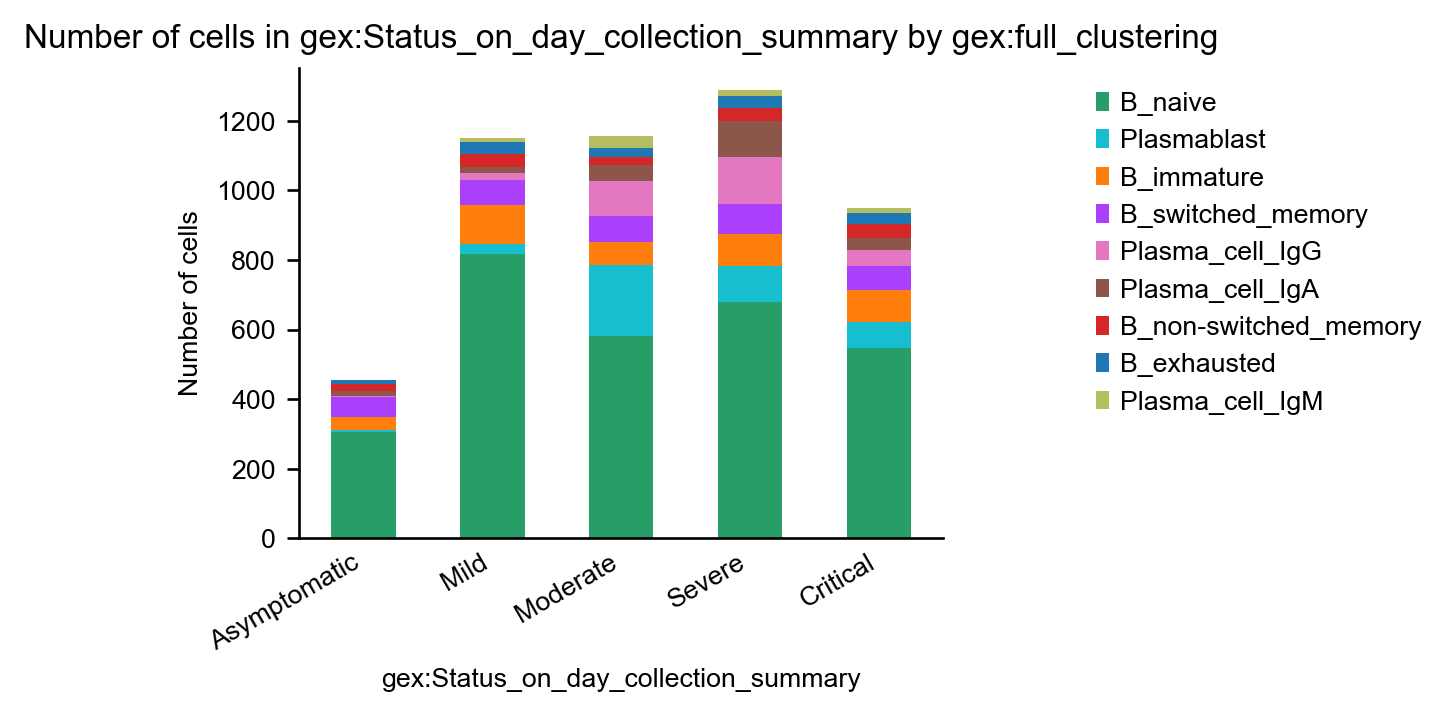

In [3]:
ir.pl.group_abundance(mdata,
                     target_col= "gex:full_clustering",
                     groupby = "gex:Status_on_day_collection_summary",
                     sort=["Asymptomatic", "Mild", "Moderate","Severe","Critical"],
                     )

Each modality is an AnnData object and behaves accordingly. More details on how to deal with Anndata object can be found [here](https://scirpy.scverse.org/en/latest/data-structure.html) and [here](https://anndata.readthedocs.io/en/stable/generated/anndata.AnnData.html#anndata.AnnData). That said, subsetting for the gene-level annotation (`.obs`) will result in a `pandas` Dataframe with all its convenient functionalities.<br>
Sorting the `.obs` layer by the number of genes ("n_genes") of the transcriptomics data reveals that the data is already preprocessed. These preprocessing steps are described in the original paper and included standard qc in Seurat, doublet removal and clustering with manual cell type annotation based on known marker genes. For transcripomics preprocessing please refer to the extensive documentation of [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) or [scverse](https://scverse-tutorials.readthedocs.io/en/latest/notebooks/basic-scrna-tutorial.html).

In [4]:
mdata["gex"].obs.sort_values("n_genes")

sample_id  n_genes  n_genes_by_counts  \
covid_index                                                             
TACGGTAGTAGAGCTG-MH9179822      MH9179822      214                214   
CCTATTAGTGTCGCTG-MH9179823      MH9179823      233                233   
CGATTGAGTCGCATCG-MH9143275      MH9143275      237                237   
TGAAAGAAGGTGTTAA-MH9143275      MH9143275      253                253   
GAACCTAGTTCACCTC-MH9179822      MH9179822      263                263   
...                                   ...      ...                ...   
BGCV05_CAGAGAGTCGAATCCA-1   BGCV05_CV0284     5161               5161   
BGCV14_CTCGAGGGTCATCCCT-1   BGCV14_CV0284     5192               5191   
S24_GTCACAACAAGGTTTC-1                AP5     5204               5204   
S24_GCACATAAGCTGCGAA-1                AP5     5897               5897   
S24_CAGAATCGTTAAGATG-1                AP5     6045               6045   

                            total_counts  total_counts_mt  pct_counts_mt  \
covid_index                                                                
TACGGTAGTAGAGCTG-MH9179822         545.0              1.0       0.183486   
CCTATTAGTGTCGCTG-MH9179823         582.0             40.0       6.872852   
CGATTGAGTCGCATCG-MH9143275         498.0              5.0       1.004016   
TGAAAGAAGGTGTTAA-MH9143275         512.0              6.0       1.171875   
GAACCTAGTTCACCTC-MH9179822         669.0             27.0       4.035874   
...                                  ...              ...            ...   
BGCV05_CAGAGAGTCGAATCCA-1        47868.0            996.0       2.080722   
BGCV14_CTCGAGGGTCATCCCT-1        41593.0           1316.0       3.163994   
S24_GTCACAACAAGGTTTC-1           51693.0            806.0       1.559205   
S24_GCACATAAGCTGCGAA-1           65817.0            558.0       0.847805   
S24_CAGAATCGTTAAGATG-1           65047.0            883.0       1.357480   

                            full_clustering initial_clustering  Resample  \
covid_index                                                                
TACGGTAGTAGAGCTG-MH9179822  Plasma_cell_IgG        Plasmablast   Initial   
CCTATTAGTGTCGCTG-MH9179823          B_naive        Plasmablast   Initial   
CGATTGAGTCGCATCG-MH9143275  Plasma_cell_IgA        Plasmablast   Initial   
TGAAAGAAGGTGTTAA-MH9143275  Plasma_cell_IgG        Plasmablast   Initial   
GAACCTAGTTCACCTC-MH9179822  Plasma_cell_IgG        Plasmablast   Initial   
...                                     ...                ...       ...   
BGCV05_CAGAGAGTCGAATCCA-1       Plasmablast        Plasmablast   Initial   
BGCV14_CTCGAGGGTCATCCCT-1   Plasma_cell_IgG        Plasmablast  Resample   
S24_GTCACAACAAGGTTTC-1          Plasmablast        Plasmablast   Initial   
S24_GCACATAAGCTGCGAA-1          Plasmablast        Plasmablast   Initial   
S24_CAGAATCGTTAAGATG-1          Plasmablast        Plasmablast   Initial   

                           Collection_Day  ... Status      Smoker  \
covid_index                                ...                      
TACGGTAGTAGAGCTG-MH9179822             D0  ...  Covid  Non-smoker   
CCTATTAGTGTCGCTG-MH9179823             D0  ...  Covid  Non-smoker   
CGATTGAGTCGCATCG-MH9143275             D0  ...  Covid      Smoker   
TGAAAGAAGGTGTTAA-MH9143275             D0  ...  Covid      Smoker   
GAACCTAGTTCACCTC-MH9179822             D0  ...  Covid  Non-smoker   
...                                   ...  ...    ...         ...   
BGCV05_CAGAGAGTCGAATCCA-1              D0  ...  Covid  Non-smoker   
BGCV14_CTCGAGGGTCATCCCT-1             D28  ...  Covid  Non-smoker   
S24_GTCACAACAAGGTTTC-1                 D0  ...  Covid  Non-smoker   
S24_GCACATAAGCTGCGAA-1                 D0  ...  Covid  Non-smoker   
S24_CAGAATCGTTAAGATG-1                 D0  ...  Covid  Non-smoker   

                           Status_on_day_collection  \
covid_index                                           
TACGGTAGTAGAGCTG-MH9179822                   ITU_O2   
CCTATTAGTGTCGCTG-MH9179823               

The following steps will reduce some of the observed genes as we excluded all celltypes not annotated as B-cells or plasmablasts. All cells had already at least 242 genes so no further processing is required.

In [5]:
sc.pp.filter_genes(mdata["gex"], min_cells=10)
#sc.pp.filter_cells(mdata["gex"], min_genes=100)

filtered out 12107 genes that are detected in less than 10 cells


Using the umap calculated from the original data we can examine two coarse clusters B-cells and Plasmablast. Further subclustering led to 9 distinct celltype annotation as it can be seen below. Further we highlighted three canonical marker and can confirm that these correspondend to their respective cluster labels <br>
1. TCL1A is described to be a marker for naive B cells [Xu et al.,2022](https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2021.816745/full)
2. IGHA1 a well known marker for IgA+ plasma cells [Stephenson et al.,2021](https://www.nature.com/articles/s41591-021-01329-2#Sec2)
3. Proliferation marker MKI67 associated with plasmablasts associaed with severe SARS-CoV-2 infection [Stephenson et al.,2021](https://www.nature.com/articles/s41591-021-01329-2#Sec2) [Bernardes et al.,2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7689306/)

C:\Users\km930\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\km930\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\km930\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\km930\anaconda3\Lib\site-packages\sca

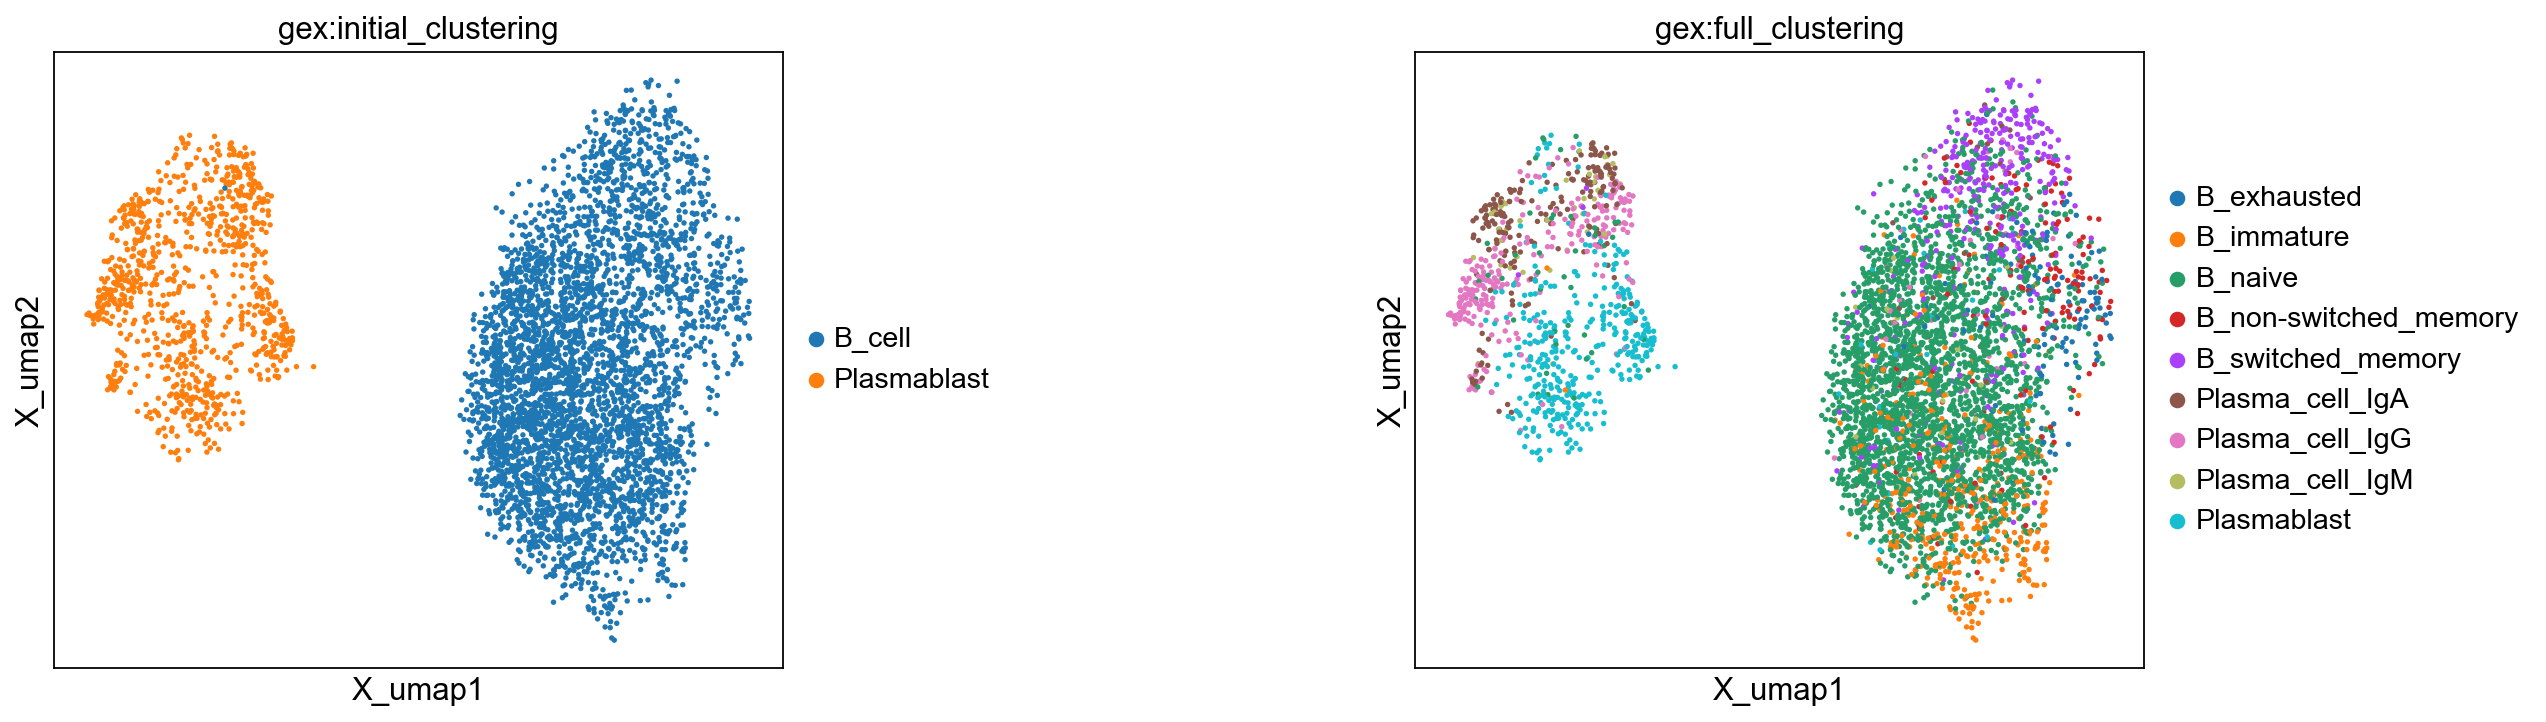

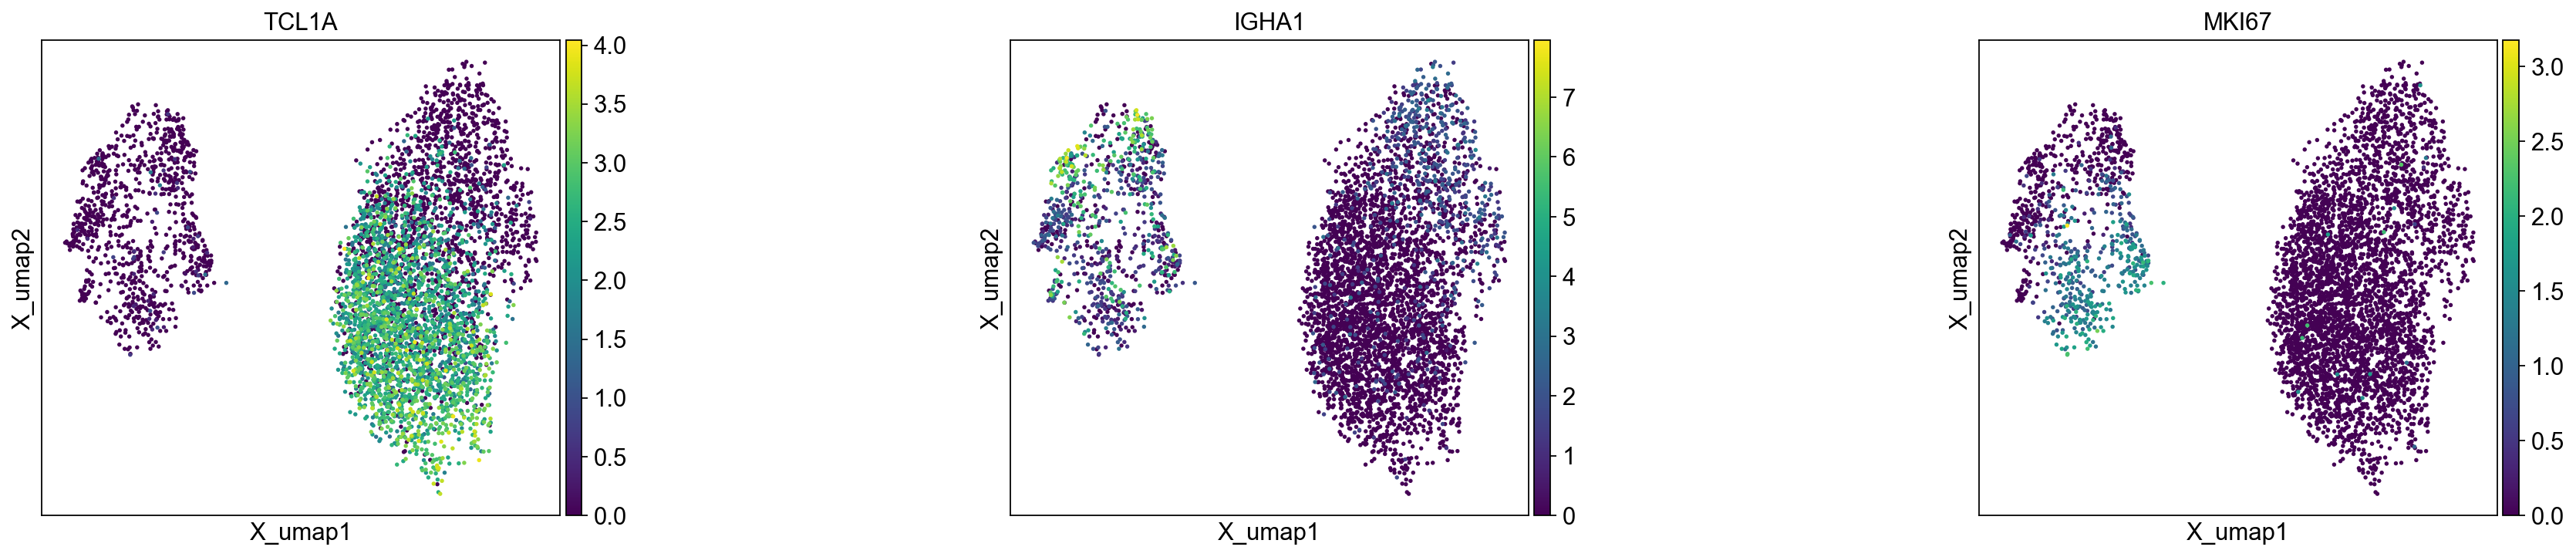

In [6]:
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color=["gex:initial_clustering", "gex:full_clustering"],
    ncols=2,
    wspace=0.7,
)
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color=["TCL1A", "IGHA1", "MKI67"],
    ncols=3,
    wspace=0.7,
)

## Preprocessing AIRR data
It is very important to understand that this AIRR data is already extensive processed. The original dataset was generated using Cell Ranger v4.0.0 which is a very popular protocol for generating and preprocessing single cell RNA data. However, unlike TCR data it is not recommended to directly use the output of Cell Ranger. Best practice is to reannotate the gene annotation with IgBlast or IMGT/HighV-QUEST, because Cell Ranger currently does not support the IMGT unique numbering scheme [Lefranc et al., 2003](https://www.sciencedirect.com/science/article/abs/pii/S0145305X02000393?via%3Dihub), which is heavily used by many downstream analysis tools (e.g. phylogenetic analysis). <br>
Either way this tutorial does not show how to reannotate contigs based on Cell Ranger fasta and annotation files. This vignette assumes that the user already did the reannotation step or that he is willing to procede without it. The reannotation steps are currently not native to Scirpy and the user has to use external tools for this. Therefore, it is recommended to benefit from Scirpy's interoperability with Dandelion [Suo et al., 2023](https://www.nature.com/articles/s41587-023-01734-7) as Dandelion is able to do all necessary preprocessing steps and even provides some optional one's. There is a great tutorial [here](https://sc-dandelion.readthedocs.io/en/latest/notebooks/1_dandelion_preprocessing-10x_data.html#) and it even comes now with a singularity container that helps to set up all R and Python dependencies. Note, that there are two functions in each package, which easily allow the transfer between the used data objects of each package. This allows user to conveniently switch between both packages and utilize combined functionalities for an advanced analysis. <br>
After obtaining a postprocessed data object, the first step for AIRR analysis in Scirpy is to create chain indices, which is taken care by the function `scirpy.pp.index_chains`. This way Scirpy keeps track of how many chains per cell are in the data. The Scirpy [receptor model](https://scirpy.scverse.org/en/latest/ir-biology.html) allow up to two paired chains per cell and makes analysis of allelically/isotypically included B cells possible [Roberta Pelanda (2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3972342/). This function also filters out non-productive chains and chains without a valid CDR3 amino acid sequence (by default).

In [7]:
ir.pp.index_chains(mdata, filter = ["productive","require_junction_aa"])

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array


`scirpy.tl.chain_qc` essentially adds three columns to the `.obs` column of the `airr` modality that can be used for visualization and subsequent filtering steps. It uses the AIR-sequence data stored as a awkward array (under mdata["airr"].obsm["airr"]) to flag cells accordingly. `receptor_type` just coarsely distinguishes between TCR and BCR. `receptor_subtype` on the other hand serves as a more specific flag to further distinguish within receptor types e.g. between the light chain classes lambda and kappa (IGH+IGK and IGH+IGL). There is now also a new flag available (IGH+IGK/L) to easily identify isotypically included b cells that productively express both lamba and kappa light chains [Shi et al.,2019](https://www.nature.com/articles/s41421-019-0137-3#Sec2). Further, `chain_pairing` can be utilized to easily identify cells with either one single heavy or light chain (orphan chains) or an additional heavy or light chain (extra chains). Further, also cells with two paired heavy and light chains (two full chains) and more (multichain) are labelled accordingly. Everything that doesn't belong to either category will be flagged as ambiguous.

In [8]:
ir.tl.chain_qc(mdata)

Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


It is rather easy to visualize these qc metrics using `scirpy.pl.group_abundance`. For a dataset with less samples/patients this could also be grouped by patients to exclude faulty or unusual looking data prematurely or to analyze it in a distinct manner. Here, it is more appropriate to use the `Status_on_day_collection_summary` in the `.obs` column of the transcriptomics modality. <br>
With the first plot it can be confirmed that no cells with missing chains (orphans) or potential doublets are left (multichain). Note, that most of the data are labelled `single pair` (as expected). The second plot confirms that overall there are more kappa than lambda chains, while isotypically included B cells are found rarely in all patient-groups. The third plot gives an idea about the B cell subpopulation distribution among patient-status. Note, the potential trend in increasing plasmablasts/plasma cells with increasing COVID-19 severity (although this might not hold between `Severe` and `Critical`)

C:\Users\km930\project\scirpy_BCR\scirpy\util\__init__.py:453: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return 1 / cast(np.ndarray, obs.groupby(normalize_col)[normalize_col].transform("count").values)
C:\Users\km930\project\scirpy_BCR\scirpy\util\__init__.py:453: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return 1 / cast(np.ndarray, obs.groupby(normalize_col)[normalize_col].transform("count").values)
C:\Users\km930\project\scirpy_BCR\scirpy\util\__init__.py:453: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to 

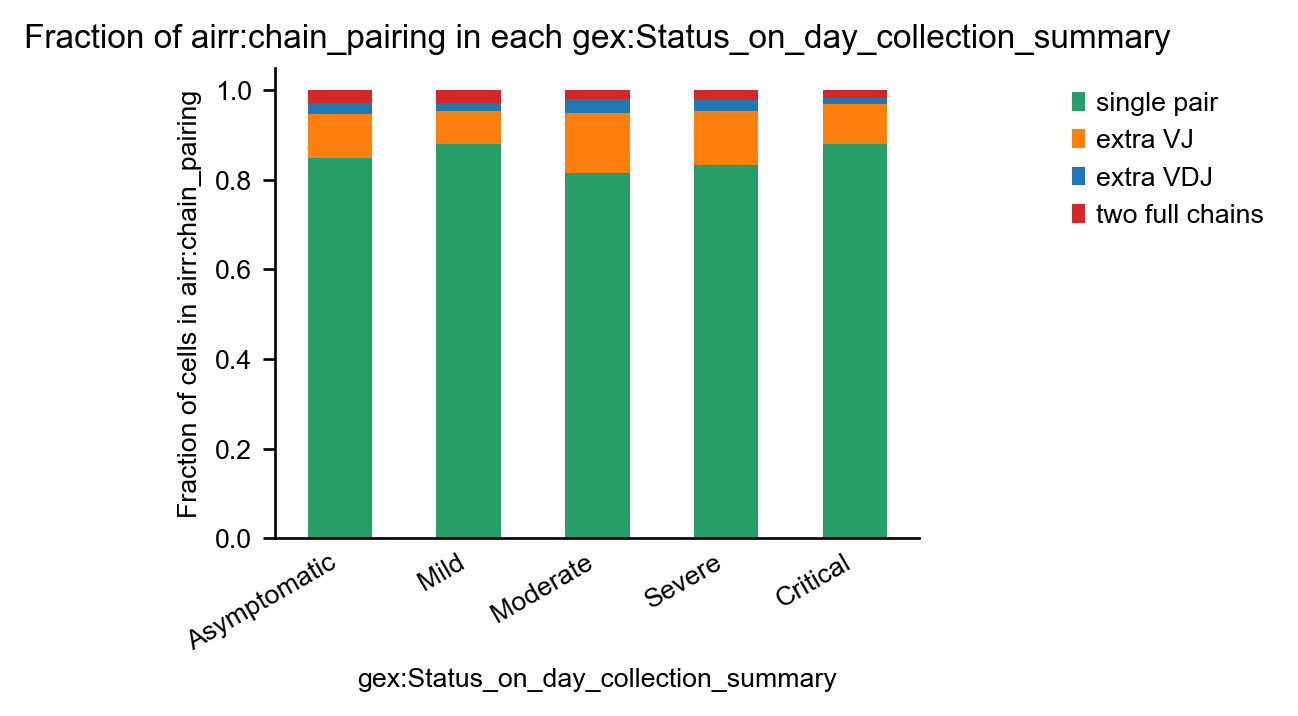

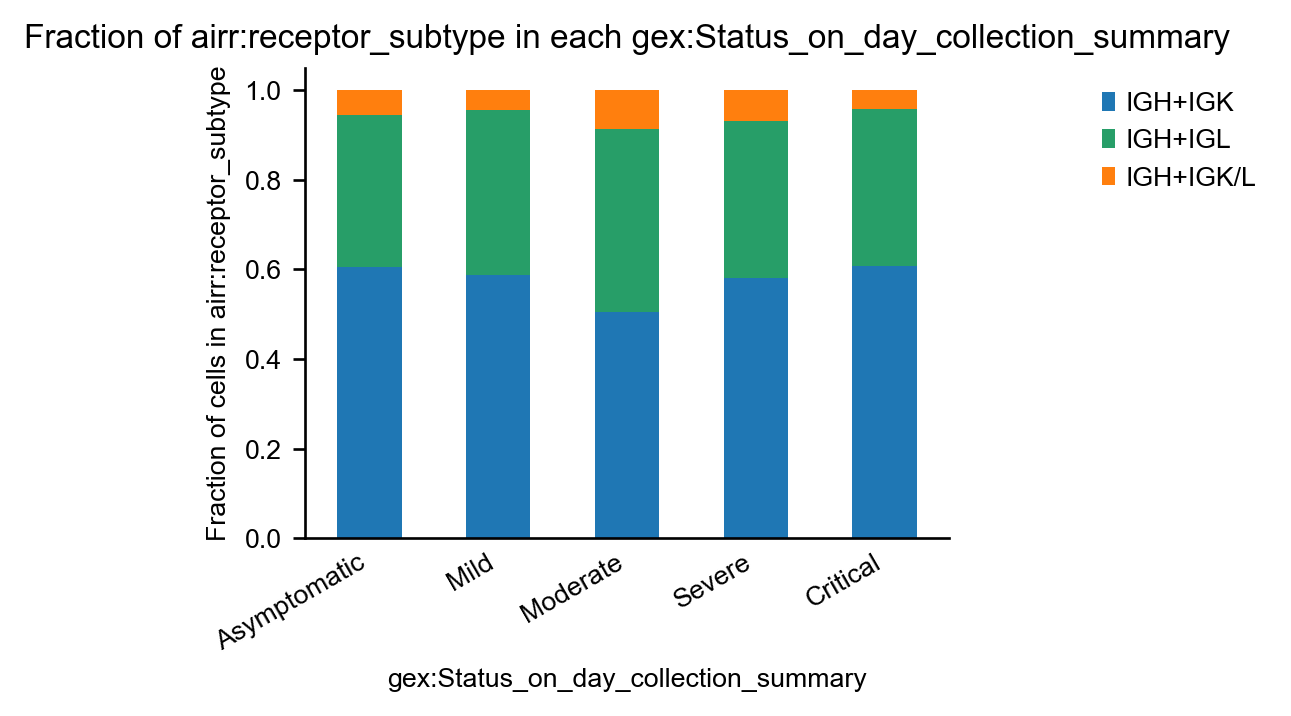

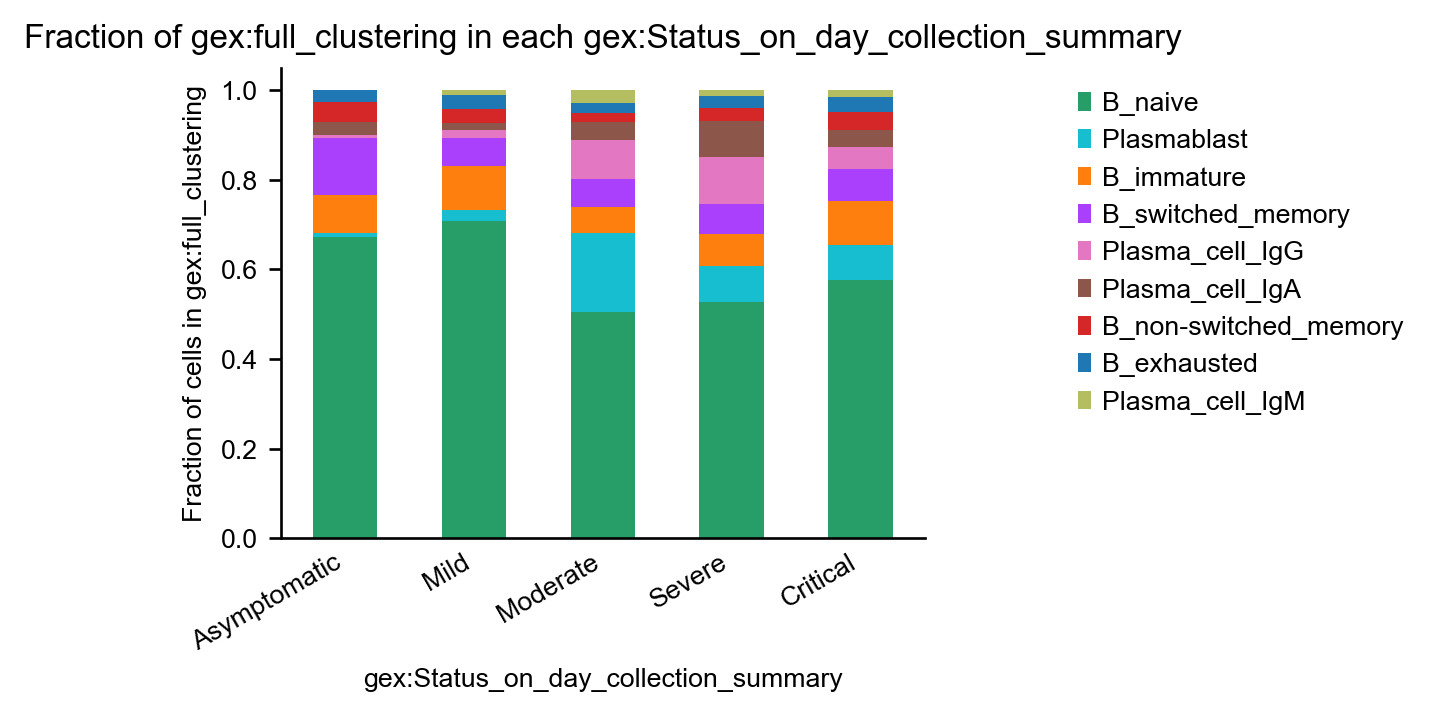

In [9]:
_=ir.pl.group_abundance(
    mdata,
    groupby="gex:Status_on_day_collection_summary",
    target_col="airr:chain_pairing",
    normalize=True,
    sort = ["Asymptomatic", "Mild", "Moderate", "Severe", "Critical"]
)

_ =ir.pl.group_abundance(
    mdata,
    groupby="gex:Status_on_day_collection_summary",
    target_col="airr:receptor_subtype",
    normalize=True,
    sort = ["Asymptomatic", "Mild", "Moderate", "Severe", "Critical"]
)
_=ir.pl.group_abundance(
    mdata,
    groupby="gex:Status_on_day_collection_summary",
    target_col="gex:full_clustering",
    normalize=True,
    sort = ["Asymptomatic", "Mild", "Moderate", "Severe", "Critical"]
)

## Definition of Clonotypes and Clonotype Cluster with Scirpy
First of all, it is important to clarify and define the term clonotype, because it is often used ambiguously in immunogenetic analysis. A strict definition of clonotype would correspond to a B/T-cell with a unique V(D)J-nucleotide sequence. Because of SHM it is sometimes more useful to use the term sub-clonotype. Sub-clontype are a group of cells that are using the same V-gene and the same CDR3 sequence, but are allowed to differ in the remaining V-Region. [Sofou et al.,2023](https://www.nature.com/articles/s41375-023-01952-7). However, it is a critical step in AIRR-seq to determine which sequences originated from a common unmutated germline sequence and thus are related. In `Scirpy` we refer to this as a clonotype cluster (other often used terms are clonal family, clonotype groups or clonal groups). This is distinct from scTCR-analysis, where a clonotype cluster refers to cells that have evolutionary converged and recognize similar antigens as described in our [TCR turorial](www.scirpy.com)
<br>
It is important to understand that there is currently no best practice or perfect approach on how to define clonotype cluster for BCR as it's still an active research field [Yaari and Kleinstein 2015](https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-015-0243-2#Abs1). There exist many different approaches such as maximum-likelihood [Ralph and Matsen, 2016](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005086), hierarchical clustering [Gupta et al.,2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5340603/), spectral clustering [Nouri and Kleinstein, 2018](https://pubmed.ncbi.nlm.nih.gov/29949968/), natural language processing [Lindenbaum et al., 2020](https://academic.oup.com/nar/article/49/4/e21/6039915) and network based approaches [Bashford-Rogers2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3814887/) [Wu2022](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9564088/). Each of these methods have been already broadly used and been shown to be effective, but there is still a lack of in-depth comparison studies to claim that any approach would be better over another. That said, there was a recent comparison study revealing that more sophisticated clonal inferrence approaches don't outperform rather straightforward ones [Balashova et al.,2024](https://bmcimmunol.biomedcentral.com/articles/10.1186/s12865-024-00600-8#Sec2).
<br>
With this information in mind we will show now what is currently possible with Scirpy. Scirpy used a network based approach to cluster TCR sequences that might target the same epitope [Sturm et al.,2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7751015/). We made recently use of this existing infrastructure to define BCR clonotype cluster in a similar manner with a network-based approach.

We implemented a new distance metric called "normalized_hamming" which calculates the hamming distance between junction sequences normalized on their respective length. This is useful to treat longer and smaller junction sequences equally [Gupta et al.,2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5340603/). Hamming distance is defined to be only valide for sequences with the same length and therefore the value in the sparse distance matrix will be 0 if two sequences have a different junction length. By using either "hamming" or "normalized_hamming" as a metric we are assuming that members of a clonotype cluster have the same junction-length which might be a source of bias [Kepler et al.,2014](https://www.cell.com/cell-host-microbe/fulltext/S1931-3128(14)00298-4?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS1931312814002984%3Fshowall%3Dtrue).
<br>
With scirpy.pp.ir_dist we can calculate the full pairwise-distance matrix between each junction sequence for each light and heavy chain in the dataset. By setting min_dist_histogram to True the distance-to-nearest distribution of the junction sequences between VJ-chains (light) and VDJ-chains (heavy) will be displayed seperately. For now we can set no cutoff (cutoff = 101) or use a broadly used relative threshold of 85% junction similarity (cutoff = 16). This cutoff also serves to make effective use of the implemented sparse matrix. Further, because Scirpy uses a sparse matrix all distances are offset by 1 as described in the API. That's because values exceeding the cutoff or sequences with different lengths will get assgned a value of 0 and identical sequences a value of 1. The last important parameter sequence decides if the aminoacid sequence or the nucleotide sequence is used to calculate the pairwise distance matrix. Although, both have been rigorously used in the literature it's recommended to use nucleotide (nt) similarity instead of aminoacid similarity (aa) because SHM acts on the nucleotide level [Yaari and Kleinstein 2015](https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-015-0243-2#Abs1).

Computing sequence x sequence distance matrix for VJ sequences.


Calculating Hamming Distances:   0%|          | 0/3624 [00:00<?, ?it/s]

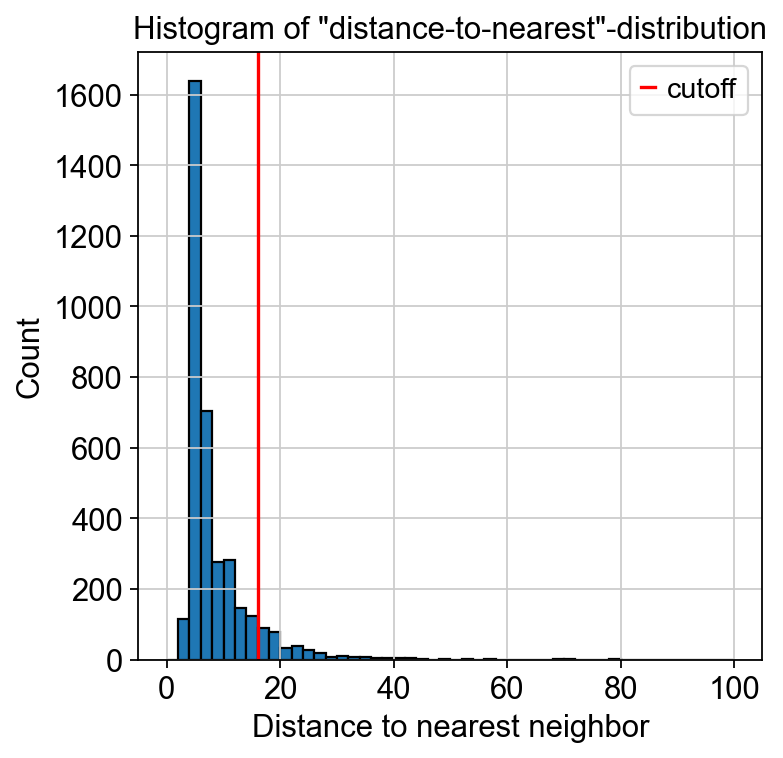

Computing sequence x sequence distance matrix for VDJ sequences.


Calculating Hamming Distances:   0%|          | 0/5020 [00:00<?, ?it/s]

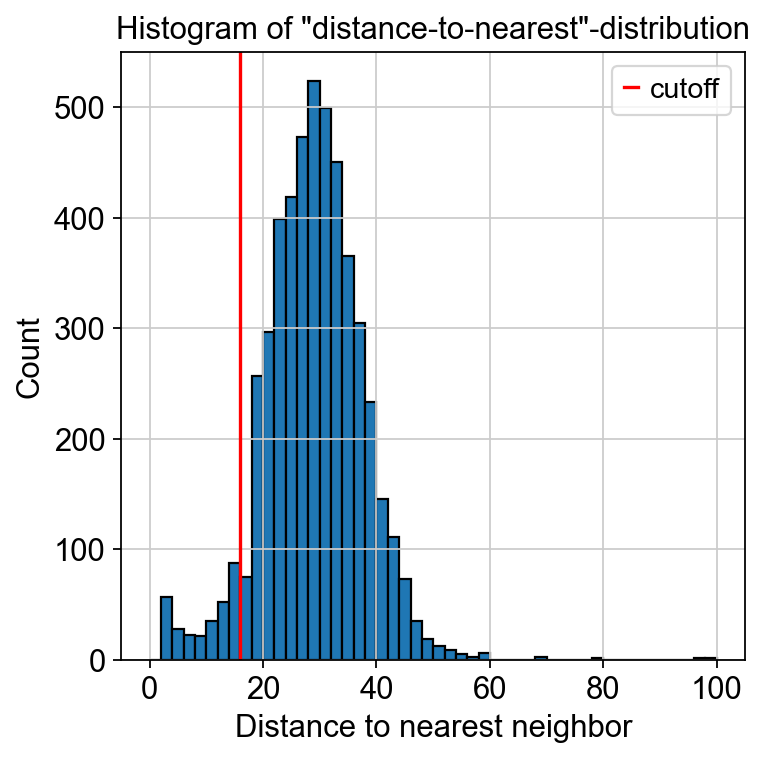

In [10]:
ir.pp.ir_dist(mdata, metric = "normalized_hamming", cutoff = 16, sequence = "nt", min_dist_histogram = True)

Further, it can be beneficial to choose a datasset-based cutoff that can seperate the bimodality between sequences with closely related sequences from sequences without closely related sequences [Gupta2017]. This bimodality can be examined in the distance-to-nearest plot, but isn't always visible. However, such an adjusted threshold isn't guaranteed to yield better resolution than a fixed absolute or relative threshold. In this particular case we can see that the bimodality appears rather weak and that the used cutoff already succeeds to divide both modalities. However, it's possible to be more conservative and use a similarity threshold of 90% instead.
<br>
Here, we will use for demonstration purposes a similar clonotype cluster definition than in the original study [Stephenson et al.,2021](https://www.nature.com/articles/s41591-021-01329-2#Sec2). Using a cutoff of 16, but with the parameter "sequence" set to "nt" instead of "aa". Note, that the distance-to-nearest distribution between heavy and light chains are quite different. In such a case it's recommended to orientate the cutoff based on the VDJ-sequences as they have more diversity[Gupta et al., 2017].

After calculating the pairwise distance matrix with `scirpy.pp.ir_dist` we can use `scirpy.tl.define_clonotype_clusters` to actually define the clonotype cluster. This function makes use of the previous defined pairwise distance matrix so that the order of function calling is crucial.
In scirpy.tl.define_clonotype_clusters are several possibilities to further costumize clonotype cluster definition. It is common to assume that sequences descending from a common ancestor using both the same v-gene and j-gene[Yaari and Kleinstein 2015](https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-015-0243-2#Abs1).This can be accomplished by setting the boolean parameter `same_v_gene` and `same_j_gene` to True, respectively. These parameter assume that the annotated gene calls are stored inside the Awkward array under "v_call" and "j_call" respectively. Unfortunately, this cannot be changed by the user and so it has to be confirmed that the right annotation information is stored under the right column name before using this function. Further, reannotation with IgBlast/IMGT-HighV-QUEST will include Allele information as well as part of the gene annotation indicated after an asterisk(\*). It might be beneficial to not include Allele information for the following clustering step by manually manipulating the respective columns. Similar means for ambiguous annotations, where it might be beneficial to pick the first and most likely annotation for clustering. Note that this workaround might be unnecessary in future Scirpy versions as it's less convenient and might introduce some bias into the analysis
<br>
Together with allowing for junction simmilarity of 85% (cutoff = 16) this mimics the setup investigated in this previous mentioned comparison study, which was shown to yield good results for clonal family inferrence. [Balashova et al.,2024](https://bmcimmunol.biomedcentral.com/articles/10.1186/s12865-024-00600-8#Sec20).<br>
That said there are still some further parameter for customization purposes. <br>
We could stringently prohibit clusters to span across individuals by setting within_group to a observation column with patient information (e.g. patient_id). However, there is evidence for public clones existence, but they tend to be rare in the case of the heavy chain sequences [Glanville et al.,2011](https://www.pnas.org/doi/full/10.1073/pnas.1107498108).
<br>
By setting `receptor_arms` to `all` both VDJ and VJ sequences have to fullfill all selected criteria in order to belong into the same clonotype cluster. Alternatively it could be set so that either VDJ or VJ sequences determine clonotype clustering, but this isn't recommended as Scirpy deals with single cell data that enable heavy and light pairing [DeKosky et al.,2013](https://www.nature.com/articles/nbt.2492#rightslink). <br>
By setting `dual_ir` it can be chosen how to deal with allelically/isotypically included B cells for the clonotype cluster definition. If it is set to `primary_only` Scirpy uses only the most abundant VDJ/VJ pair for clonotype cluster assignment. Here we set it to `any` so that just either of the chain-pairs as to fullfill all the previous settings and not both (`all`). However, this is rather experimental as most clonotype inferrence approaches filter multiple heavy and light chains cells before calling clonotype cluster assignment.<br>
With all these information and restrictions Scirpy is able constructs a network were each node represents a unique junction sequence and the size of the node represents how many identical sequences this node contains. Nodes that are below the distance cutoff for both heavy and light chain and either of the two IR pairs and fullfill all other criteria (here having same v-gene andd j-gene) will be connected by an edge. The last important parameter `partitions` will specify how or if these edges should be further divided. Current optios are `connected`, `leiden` and `fastgreedy`. `connected` doesn't perform any further division and connects any node that fullfiles all requirements. `leiden` performs the well-known Leiden algorithmus [Traag et al.,2019](https://www.nature.com/articles/s41598-019-41695-z) which might lead detect further subcluster within cluster although this isn't rigorously tested yet. The last algorithmus performs a greedy hierarchical clustering on the established graph, which again might lead to some smaller subcluster, especially if cluster are weakly connected [Clauset et al.,2004](https://arxiv.org/abs/cond-mat/0408187)<br>
Lastly, the name of the `.obs` column can be customized by setting `key_added` so that multiple defintions of clonotype clustering can be used and compared. <br>
Calling scirpy.tl.define_clonotype_clusters will add two `.obs` columns to the `MuData` object. One with an appropriate clonotype id and the other with the associated size. The size of a clonotype cluster refers to how many distinct cells belong to this clonotype cluster.

In [11]:
ir.tl.define_clonotype_clusters(mdata,
                                sequence = "nt",
                                metric = "normalized_hamming",
                                receptor_arms = "all",
                                dual_ir = "any",
                                same_v_gene = True,
                                same_j_gene = True,
                                #within_group = "gex:patient_id", just for demonstration
                                partitions = "fastgreedy",
                                key_added = "clone_id_85_similarity"
                               )

Initializing lookup tables. 
Computing clonotype x clonotype distances.
community_fastgreedy clustering:
modularity score:  0.47305973083806135
membership:  [0, 1, 2, 3, 4, 5, 6, 2, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 16, 2, 17, 18, 19, 20, 21, 22, 23, 24, 2, 25, 26, 27, 28, 29, 30, 31, 32, 33, 2, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 42, 9, 77, 78, 79, 80, 81, 82, 40, 83, 13, 84, 85, 86, 87, 88, 89, 90, 91, 79, 92, 93, 9, 94, 95, 43, 96, 2, 97, 43, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 43, 111, 112, 113, 114, 115, 116, 117, 43, 118, 119, 120, 65, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 101, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 1, 146, 147, 148, 149, 150, 151, 8, 152, 153, 154, 155, 156, 157, 158, 40, 159, 160, 161, 162, 163, 164, 165, 166, 2, 167, 2, 168, 169, 170, 171, 75, 118, 17

Stored result in `mdata.obs["airr:clone_id_85_similarity_size"]`.


Calling `scirpy.tl.clonotype_network` will actually compute the layout for the clonotype network needed for visualization. Setting `min_cells` to an appropriate value is especially important for big datasets to not overcrowd the plot. Setting it to at least 2 in order to get rid of all singlets might be beneficial for most cases. Here, we set it to three to be more conservative and only show clonotype clusters that are certainly expanded.

In [12]:
ir.tl.clonotype_network(mdata,
                        sequence = "nt",
                        metric = "normalized_hamming",
                        min_cells = 3,
                        clonotype_key="clone_id_85_similarity")

With scirpy.pl.clonotype_network a customizable clonotype network is displayed. Colurs can be picked from any `.obs` columns to effectively visualize clusters. Further customizations are also available.<br>
The plot below shows that most expanded clonotype clusters belong to `Moderate` and `Severe` patients. It also indicates that no clonotype cluster is shared between patients, which can be proved using the clonotype id's.

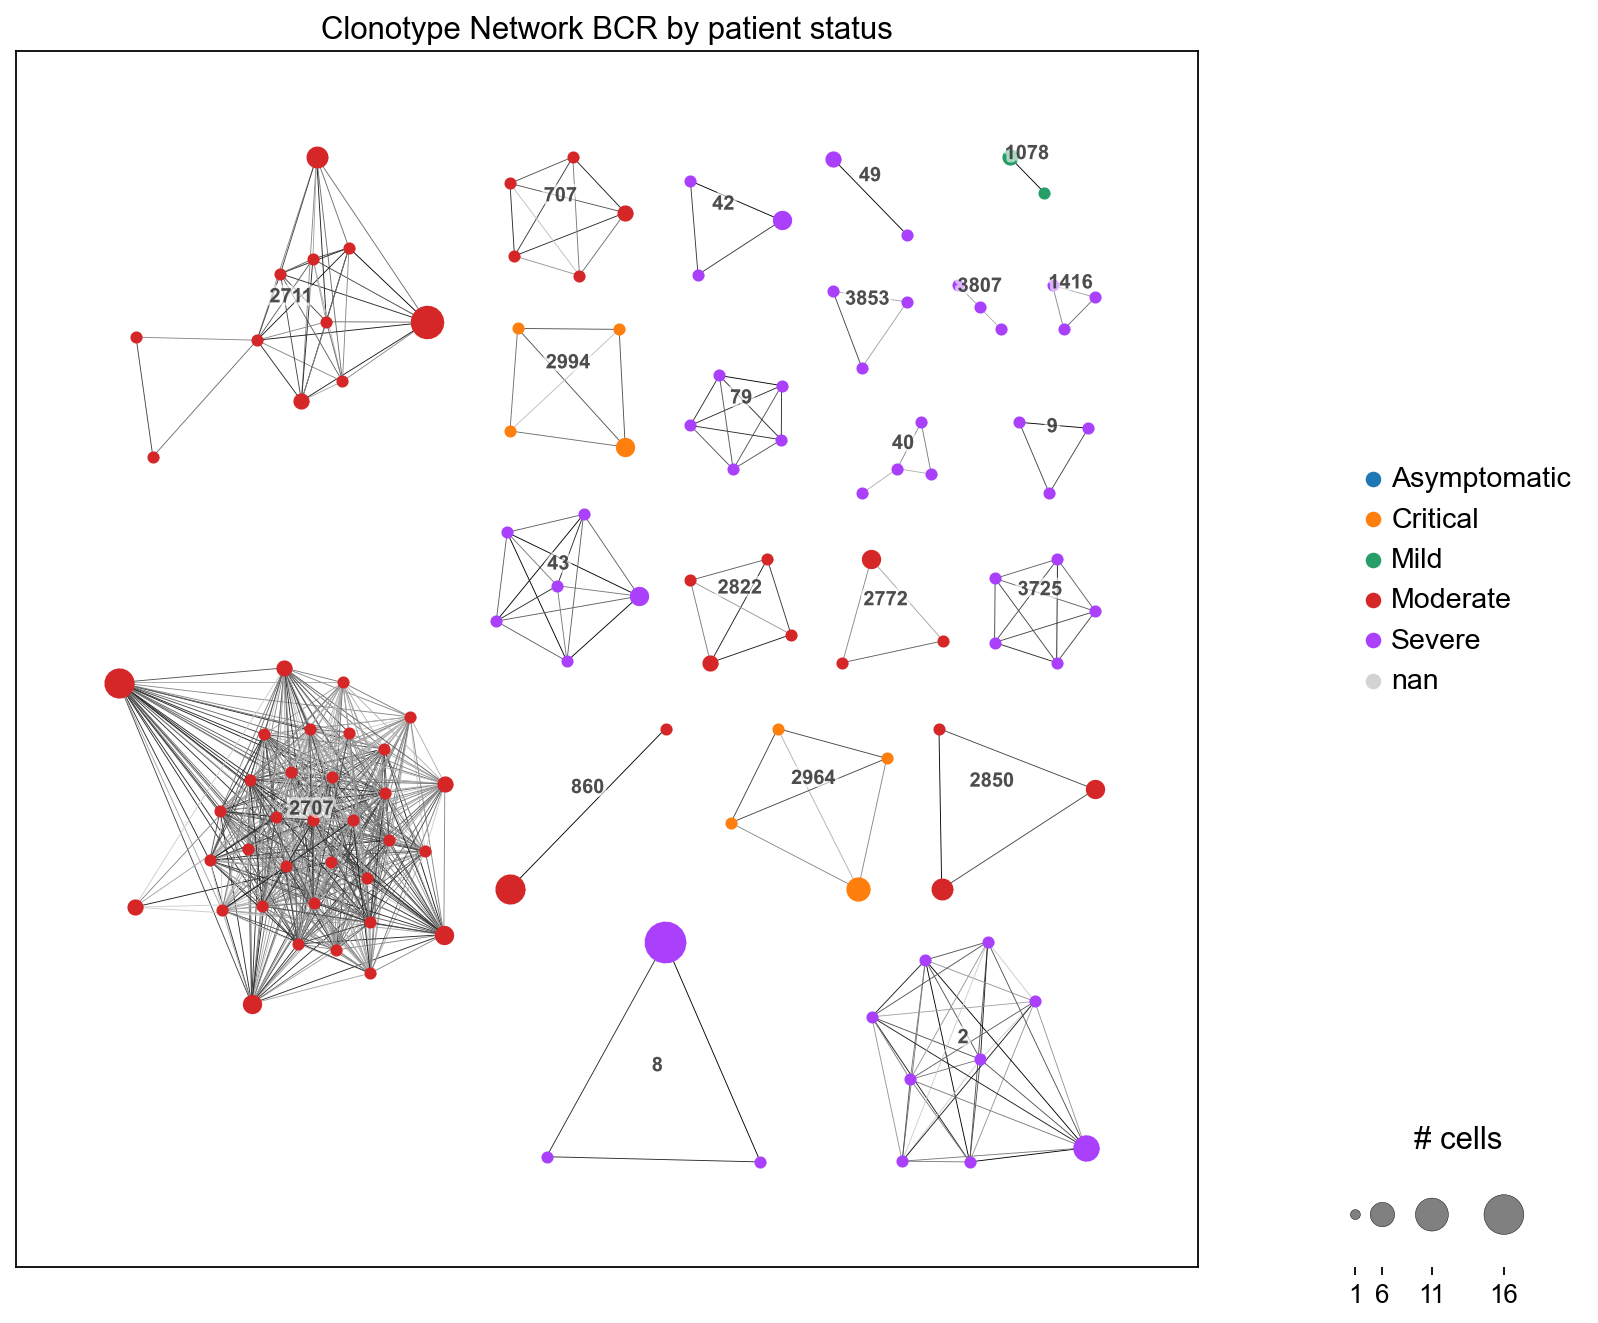

In [16]:
_=ir.pl.clonotype_network(mdata,
                        color = "gex:Status_on_day_collection_summary",
                        title = "Clonotype Network BCR by patient status",
                        label_fontsize = 9,
                        base_size=20)

As the constant region will aslo define the isotype of potential antibodies, it might be beneficial to add these column to the `.obs` column permantly to have them easily accessible. Because these columns contain ambiguous assignments we only include the first and most likely assignment to reduce the amount of categories for visualization. In general accessing the receptor information per isotype stored

In [13]:
isotypes = ir.get.airr(mdata, ["c_call"],["VDJ_1","VJ_1","VDJ_2","VJ_2"])
mdata["airr"].obs["VDJ_1_isotype"] = [None if a==None else a.split(",")[0] for a in isotypes["VDJ_1_c_call"]]
mdata["airr"].obs["VJ_1_isotype"] = [None if a==None else a.split(",")[0] for a in isotypes["VJ_1_c_call"]]
mdata["airr"].obs["VDJ_2_isotype"] = [None if a==None else a.split(",")[0] for a in isotypes["VDJ_2_c_call"]]
mdata["airr"].obs["VJ_2_isotype"] = [None if a==None else a.split(",")[0] for a in isotypes["VJ_2_c_call"]]
mdata.update()

A distribution as shown below is most likely as IgM is the first antibody to be produced as part of an immune repsonse. Also IgM and IgD are coexpressed on the surface of nàive b cells and a vast majority of this data-subset was categorized as such. IgA, IgG and IgE antibdies are expressed upon activation after class switch recombination [Stavnezer and Schrader 2014](https://journals.aai.org/jimmunol/article/193/11/5370/96293/IgH-Chain-Class-Switch-Recombination-Mechanism-and). Note, that there are no IgE, which is expected as the original data also just contains very few cells of this isotype. IGLC3 is probably a faulty assignment and should be dealt with in a real dataset.

In [14]:
mdata["airr"].obs["VDJ_1_isotype"].value_counts()

VDJ_1_isotype
IGHM     3464
IGHG1     627
IGHA1     354
IGHD      297
IGHA2      79
IGHG2      67
IGHG3      60
IGHG4       7
IGLC3       1
Name: count, dtype: int64

It is promising to see that isotype assignments and cell cluster labels are mostly coinciding.

C:\Users\km930\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\km930\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\km930\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\km930\anaconda3\Lib\site-packages\sca

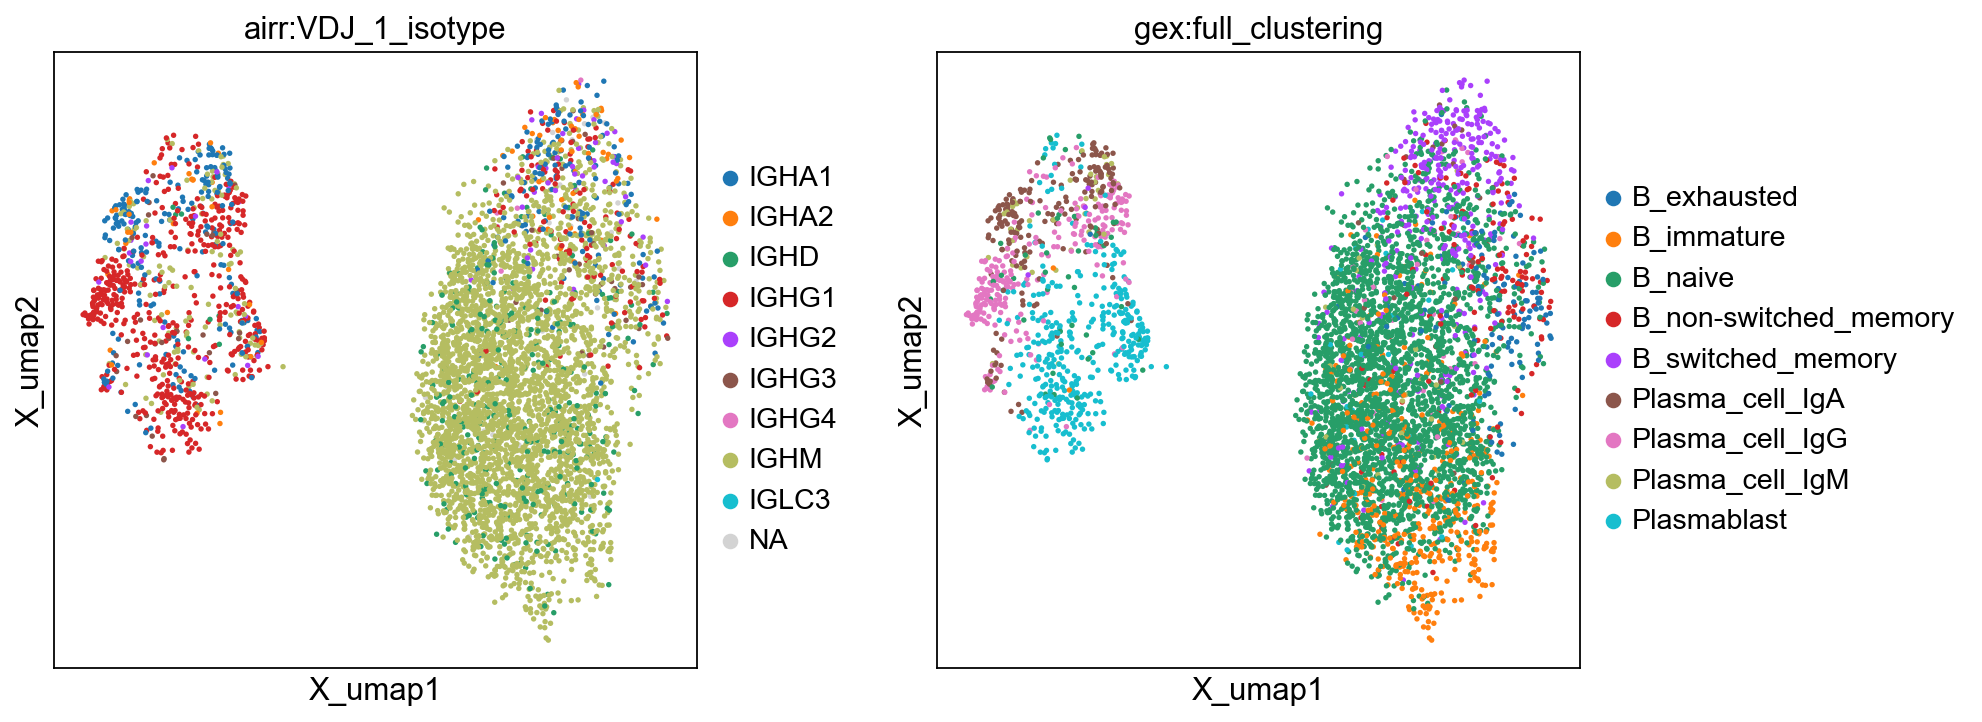

In [15]:
mu.pl.embedding(
    mdata, basis="gex:umap", color=["airr:VDJ_1_isotype","gex:full_clustering"],
    ncols=2,
    wspace=0.25
)

## Germline reconstruction
After performing clonotype clustering one might want to include information about the original (unmutated) germline sequence. While it is not possible to infer germline sequences with `Scirpy`at this point, user could again utilize the interoperability with `Dandelion`to this extend. Please refer to this excellent [tutorial](https://sc-dandelion.readthedocs.io/en/latest/notebooks/5_dandelion_diversity_and_mutation-10x_data.html) as this vignette will not specifically show how to do it.
<br>
That said, inferring the germline sequences is currently only necessary for calculating observed somatic hypermutation as covered later in this tutorial. However, if phyloegentic analysis (phylogenetic analysis is not possible inside the Scirpy evironment just yet) are deemed interesting than reconstructing germline sequences is also a crucial step.

## Clonotype Expansion

Upon infection a small number of precursor lymphocytes that recognize an invading antigen proliferate into cells with various phenotypes that establish an appropriate immune response in a process called clonal/clonotype expansion. [Adams et al., 2020](https://www.nature.com/articles/s41577-020-0307-4). Clonotype expansion is a way t characterize the immune respinse and has therefore important implications for immunologists.<br>
Using scirpy.tl.clonal_expansion adds a new `.obs` column to the `MuData` object. This function essentially labels each cell according to if there is another cell with the same clonotype id or not. The fineness of the assignment can be controled with the `breakpoints`parameter. This new column is usefull to conveniently access information about clonal expansion among different groups.

In [17]:
ir.tl.clonal_expansion(mdata,
                       target_col = "clone_id_85_similarity",
                       breakpoints = (1,2)
                      )
mdata.obs["airr:clonal_expansion"].head(5)

Stored result in `mdata.obs["airr:clonal_expansion"]`.


AAACGGGCACATTAGC-MH9179824    <= 1
AAAGATGGTATATGAG-MH9179824    <= 1
AACCATGGTCCAAGTT-MH9179824    <= 1
AACCATGGTGCAGGTA-MH9179824    <= 1
AACCGCGGTCGAGATG-MH9179824    <= 1
Name: airr:clonal_expansion, dtype: category
Categories (4, object): ['<= 1', '<= 2', '> 2', 'nan']

In [18]:
expanded = round((len(mdata[mdata.obs["airr:clonal_expansion"] !="<= 1"]) / len(mdata)) *100 , 2)
print(f' There are {expanded}% expanded (size >=2) clonotype cluster in this subsample.')

 There are 6.04% expanded (size >=2) clonotype cluster in this subsample.


This new column can be used for all sorts of plotting functions. For example, it can be used for an umap to visualize which cells are expanded. This is a rather coarsely equivalent to using the `clone_id_size` column. It is notable that the proportion of expanded cells is rather small in this subsample.<br>
This new column is also useful for the  innate scirpy.pl.group_abundance function, which is often a good fit to visualize categorical data. Here it's likely that expanded clonotypes are preferential found in cell labelled as Plasmacells, Plasmablast and exhausted B cells. This makes biologically sense for the prior two as these cell types are primary involved in the humoral immune response upon infection and proliferate rapidly [Nutt et al.,2015](https://www.nature.com/articles/nri3795).

C:\Users\km930\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\km930\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


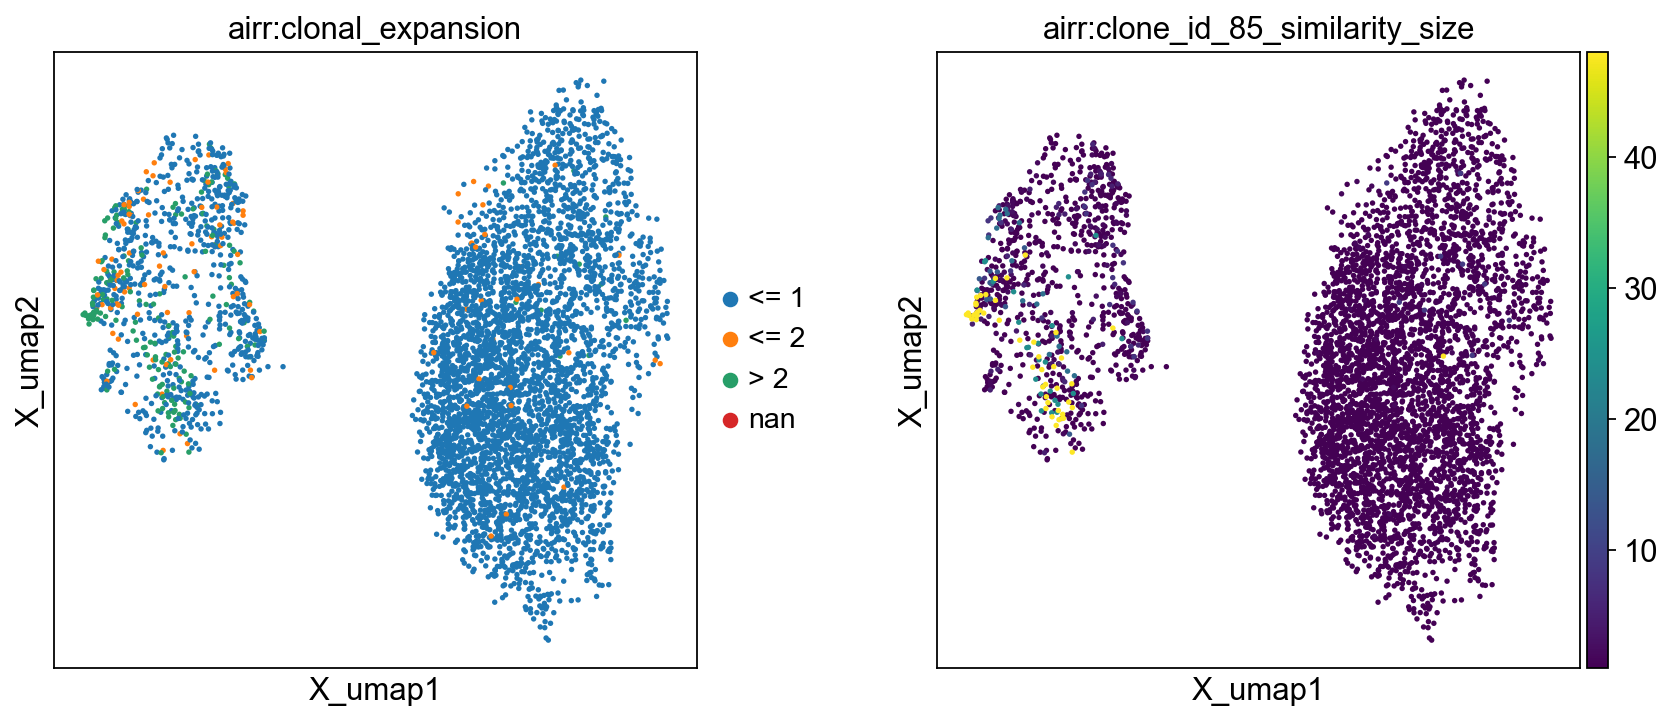

C:\Users\km930\project\scirpy_BCR\scirpy\util\__init__.py:453: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return 1 / cast(np.ndarray, obs.groupby(normalize_col)[normalize_col].transform("count").values)


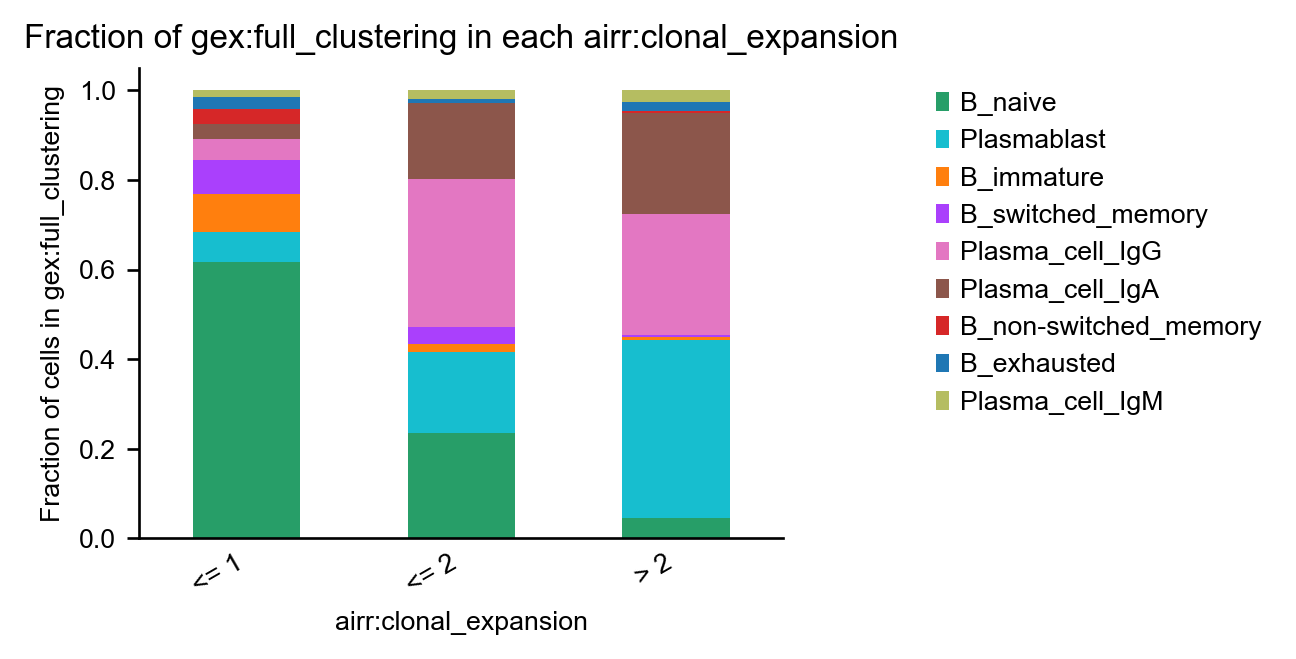

In [19]:
_=mu.pl.embedding(
    mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_85_similarity_size"],
    ncols=2,
    wspace=0.25
)

_=ir.pl.group_abundance(
    mdata,
    target_col="gex:full_clustering",
    groupby="airr:clonal_expansion",
    sort = ['<= 1', '<= 2', '> 2'],
    normalize=True)

However, Scirpy comes also with a plotting function for clonal expansion called `scirpy.pl.clonal_expansion`. Rather than using/adding a column to the `.obs` column of the data object it directy colours the clonal expansion on grouped data as a stacked bar plot. For each barplot one could adjust the categories of clonal expansion again with using the `breakpoints` parameter.<br>
The following bar plot confirms the previous one as there is just very little or no expansion in nàive, immature or switched memory B cells compared to plasmablast and plasma cells.

C:\Users\km930\project\scirpy_BCR\scirpy\util\__init__.py:453: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return 1 / cast(np.ndarray, obs.groupby(normalize_col)[normalize_col].transform("count").values)


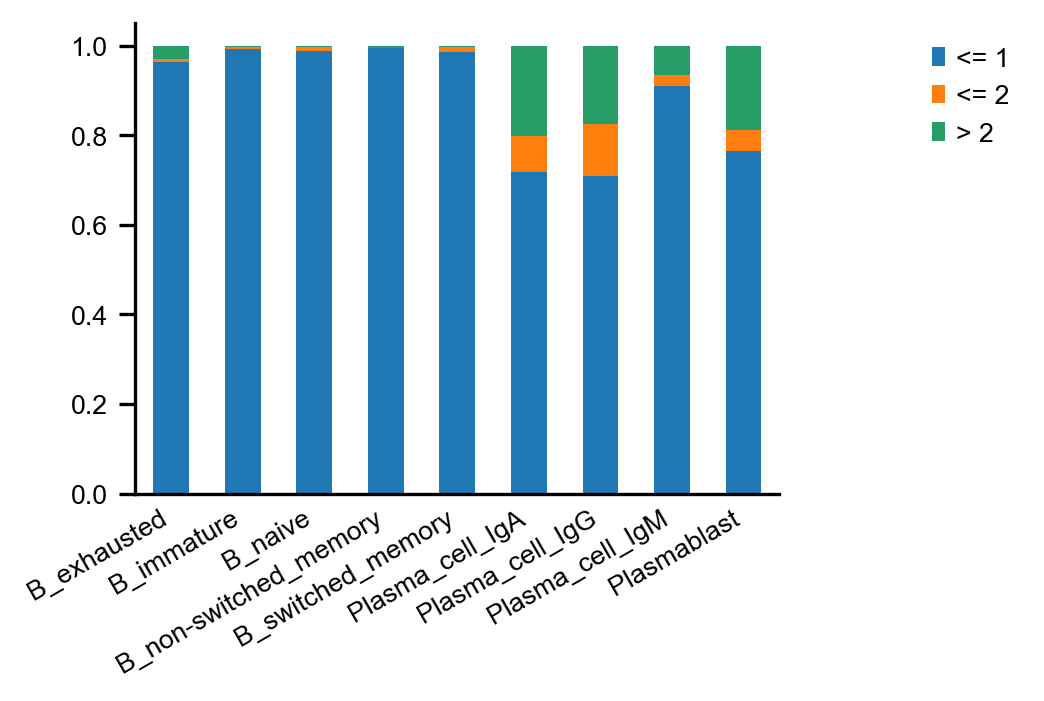

In [50]:
_=ir.pl.clonal_expansion(mdata,
                       target_col = "clone_id_85_similarity",
                       breakpoints = (1,2),
                       groupby = "gex:full_clustering",
                       normalize = True,)

## Clonotype diversity
Clonotype diversity is a rather complicated subject and different approaches work with different assumptions. However, there has been a great afford to use diversity measures invented for ecology in AIRR analysis as well. Here a B cell clonotype (cluster) is the equivalent to species and a single cell is the equivalent to an individual [Yaari and Kleinstein 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4654805/). Especially useful AIRR analyisis is alpha diversity, which is generally defined as the average species (here clonal) diversity of an population in site [Whittaker, 1972](https://onlinelibrary.wiley.com/doi/abs/10.2307/1218190). Noteable is that in sc-AIRR analysis the term population can be defined in different ways depending on the scientific question. Often it is the AIRR of an individual or of  patient group, but comaprison of different cell annotation clusters are also applicable. Further, many different alpha dversity indices for many different applications have been developed and each might introduce bias if used unwarily [Finotello et al., 2016](https://academic.oup.com/bib/article/19/4/679/2871295?login=false). <br>
However, there has been already some extensive effort to compare and evaluate different indices in use for BCR analysis. For example, a recent paper claims that Shannon entropy remains the most robust index across datasets, but recommend to use a combination of many  different indices as each index provides different information [Pelissier et al., 2023](https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2023.1123968/full).<br>
Scirpy comes with a innate alpha diversity calculation tool (`scirpy.tl.alpha_diversity`) and a corresponding visualization function (`scirpy.pl.alpha_diversity`). So far there are only three diversity indices directly integrated into Scirpy. These are Shannon entropy [Shannon, 1948](https://onlinelibrary.wiley.com/doi/abs/10.1002/j.1538-7305.1948.tb01338.x) normalized on group sizes, [Diversity 50](https://patents.google.com/patent/WO2012097374A1/en) (`D50`) and DXX. The latter two are identical in their calculation, but D50 resembles a special case of DXX. D50 is a rather recent development and was already used to compare AIRR clonal expansion in several studies.<br>
However, Scirpy can use any diversity index implemented into the python package `scikit-bio` [Rideout et al.,2023](https://zenodo.org/records/8209901), like Gini-Simpson index [Simpson, 1949](https://www.nature.com/articles/163688a0), chao1 richness estimator [Chao, 1984](https://www.jstor.org/stable/4615964) and many more. It is even capable of accepting any custom function to calculate diversity as long as it works with count vectors as explained [here](http://scikit-bio.org/docs/latest/diversity.html)<br>
To have accss to this functionalities one has to import and install the `scikit-bio` package as well (by using for example the pip command), as it is not an initial requirement for `Scirpy`.

In [21]:
#!pip install scikit-bio

Calling `scirpy.pl.alpha_diversity` with appropriate arguments for groups, desired diversity metric and where to find the clonotype id column will result into a basic bar plot as shown below. Here it is indicated that moderate and severe patients have a slightly reduced diversity compared to other groups.

<Axes: title={'center': 'Alpha diversity of clone_id_85_similarity by gex:Status_on_day_collection_summary'}, ylabel='D50'>

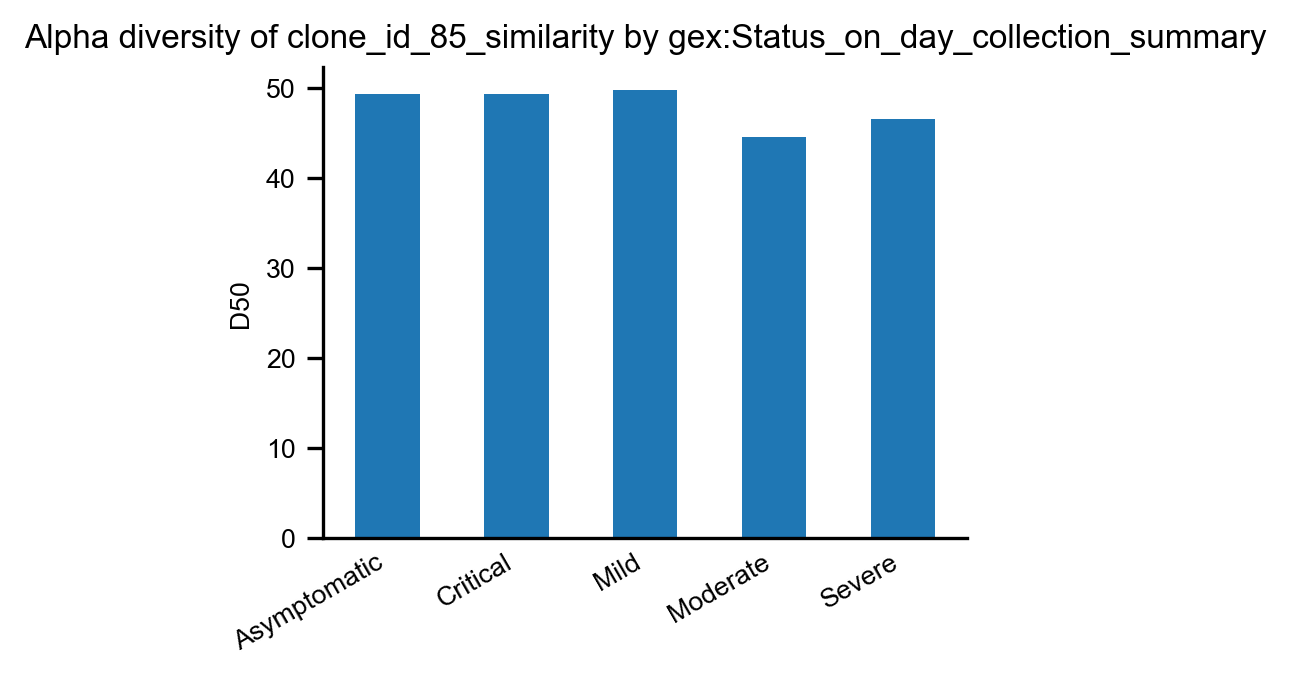

In [51]:
ir.pl.alpha_diversity(
    mdata,
    metric="D50",
    groupby="gex:Status_on_day_collection_summary",
    target_col = "clone_id_85_similarity",
)

As already mentioned, it is often best to utilize different diversity indices. Rather than plotting each individually we can build a diversity profile using Hill's unified diversity framework [Hill 1973](https://esajournals.onlinelibrary.wiley.com/doi/10.2307/1934352). This can be done using `scirpy.tl.hill_diversity_profile`, which is a new experimental function that will return a dataframe. The paramter `target_col` has to be set on the `.obs` column containing clone_id  information and the parametr `groupby` specifies on which categories the profile will be calculated. Furthermore, which range of diversiy order *q* will be calculated and its step size can be adjusted as well with the parameter `q_min`, `q_max` and `q_step`, respectively. The Hill numbers of order *q* are defined as: <br>
$^qD = (\sum_{i=1}^{S_{obs}}p_i^q)^{(\frac{1}{1-q})}$<br>
Maybe the biggest advantage of using Hill numbers is that some values for the diversity order *q* are related to other common diversity indices like species richness ($^0D$), Shannon entropy (log($^1D$), Simpson index ($\frac{1}{^2D}$) and Berger-Parker dominance index [Berger and Parker, 1970](https://pubmed.ncbi.nlm.nih.gov/17731043/) ($\frac{1}{^{\infty}D}$).

The dataframe can be easily viusalized using Seaborn or equivalent python packages. The more uneven the relativ abundances per category the more steply its respective curve will decline. This is actually consistent with alpha diversity loss and thus its magnitude can be inferred by
inspecting the slope of each line [Chao et al., 2014](https://www.uvm.edu/~ngotelli/manuscriptpdfs/ChaoHill.pdf) 

Overall, the diversity profile below is consistent with the previous analysis and suggests that expansion took place preferential in all annotated celltypes except for immature and switched memory b cells. 

In [23]:
diversity_profile_status = ir.tl.hill_diversity_profile(mdata,
                                            target_col = "airr:clone_id_85_similarity",
                                            groupby = "gex:Status_on_day_collection_summary",
                                            q_min = 0,
                                            q_max = 10,
                                            q_step = 0.5)

C:\Users\km930\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\km930\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


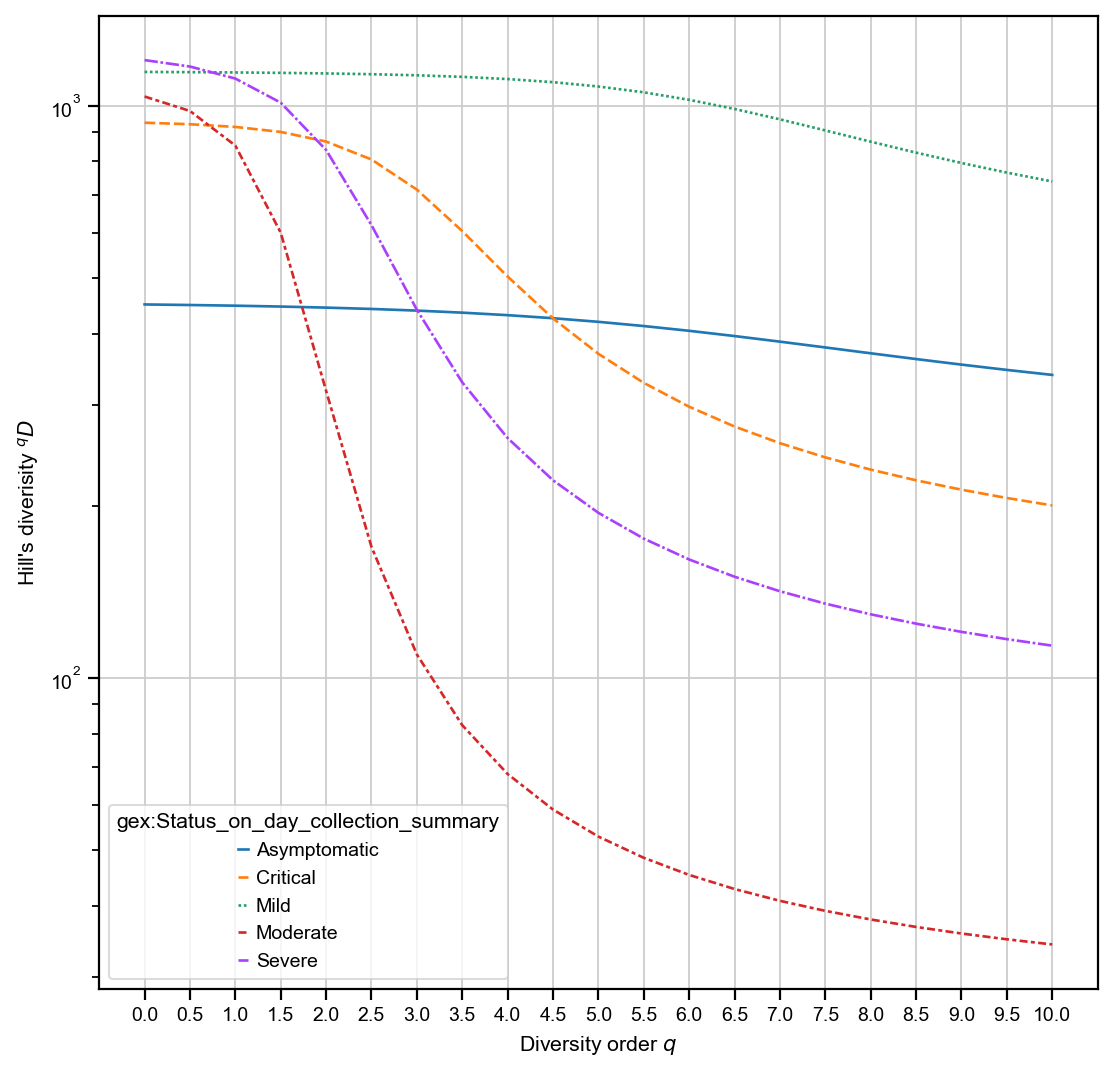

In [48]:
#manual customization of the resulting plot required
pl.figure(figsize=(8,8))
sns.set_context("paper")
sns.lineplot(data = diversity_profile_status)
pl.xlabel("Diversity order $q$")
pl.ylabel("Hill's diverisity $^qD$")
pl.yscale("log")

## Clonotype Abundance

Sometimes it might be desired to investigate the biggest clonotype cluster. This is rather easy and can be accomplished with the already well known `scirpy.pl.group_abundance` function. It's worth mentioning that the plots are easily transformated into relative representation by setting the `normalize` parameter accordingly. Note that each of the 10 largest clonotype cluster span across at least two celltype annotations.

C:\Users\km930\project\scirpy_BCR\scirpy\util\__init__.py:453: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return 1 / cast(np.ndarray, obs.groupby(normalize_col)[normalize_col].transform("count").values)


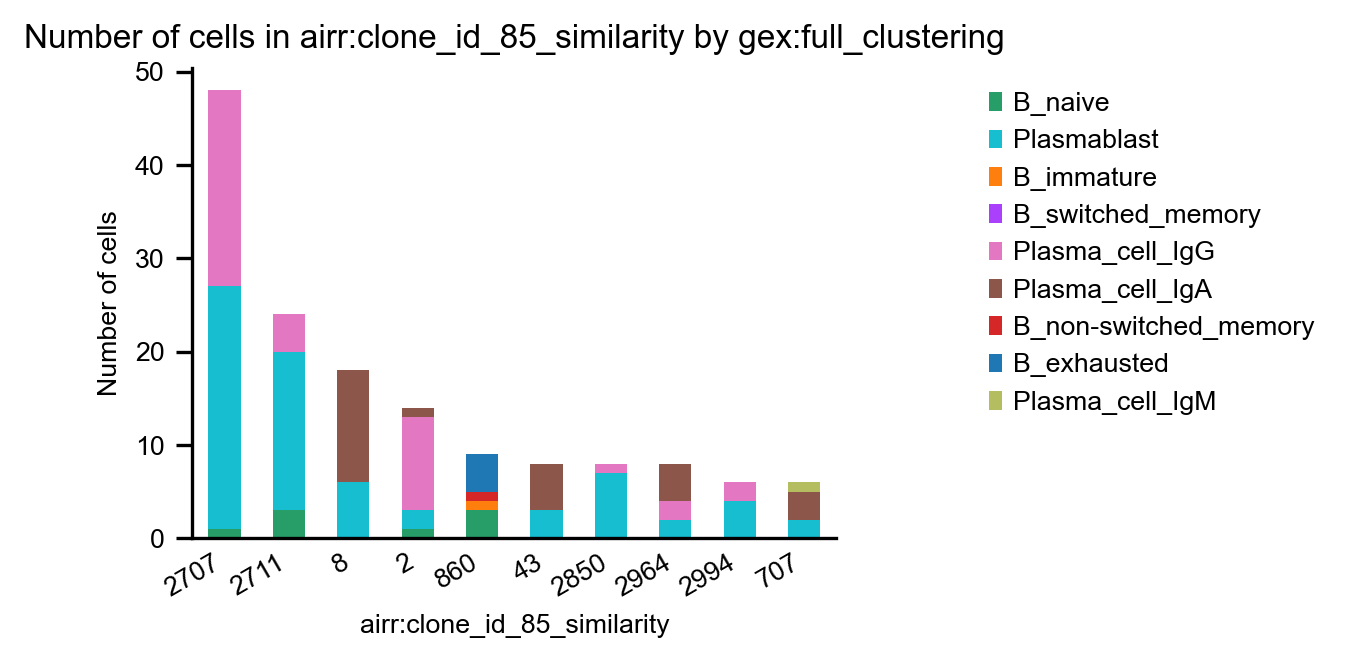

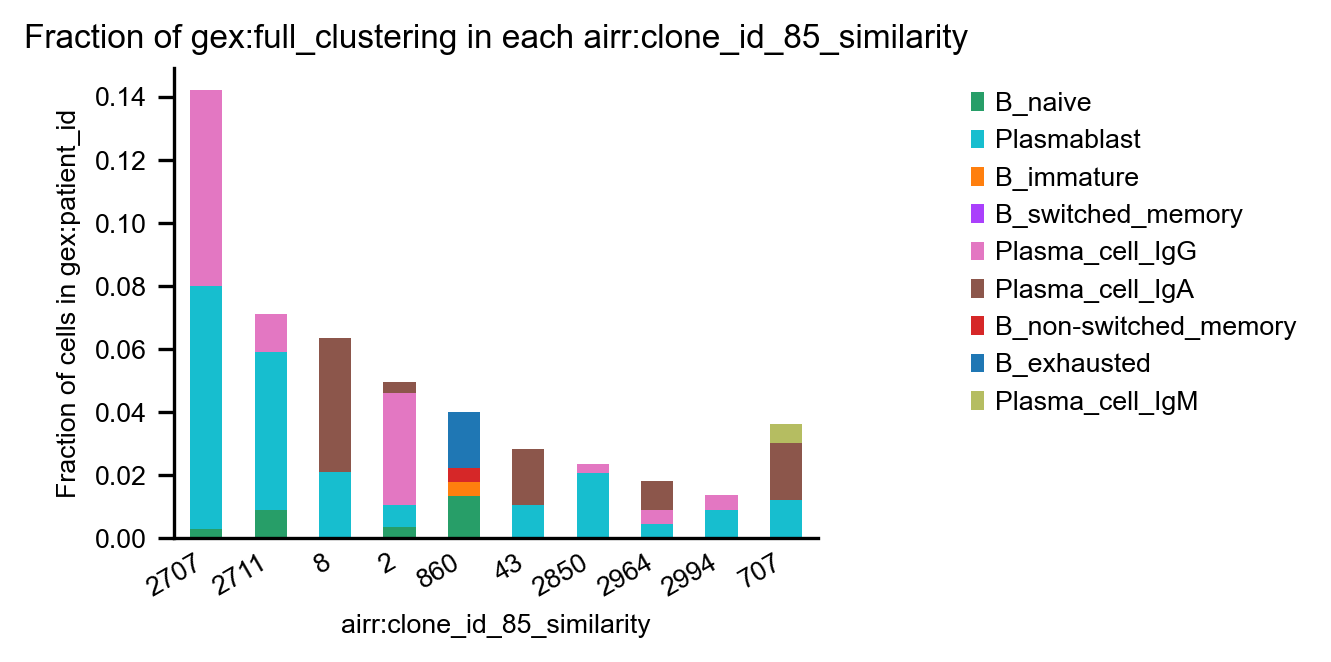

In [25]:
_=ir.pl.group_abundance(
    mdata, 
    groupby="airr:clone_id_85_similarity",
    target_col="gex:full_clustering",
    max_cols=10
)

_=ir.pl.group_abundance(
    mdata, 
    groupby="airr:clone_id_85_similarity",
    target_col="gex:full_clustering",
    max_cols=10,
    normalize = "gex:patient_id")

It's also a powerful tool to quickly get an idea which categories might be interesting for further investigation. For example, the following plots suggest that there are a lot of expanded IGHG1 and IGHM isotypes and that in the patient status "Moderate" are some of the biggest clonotype clusters.

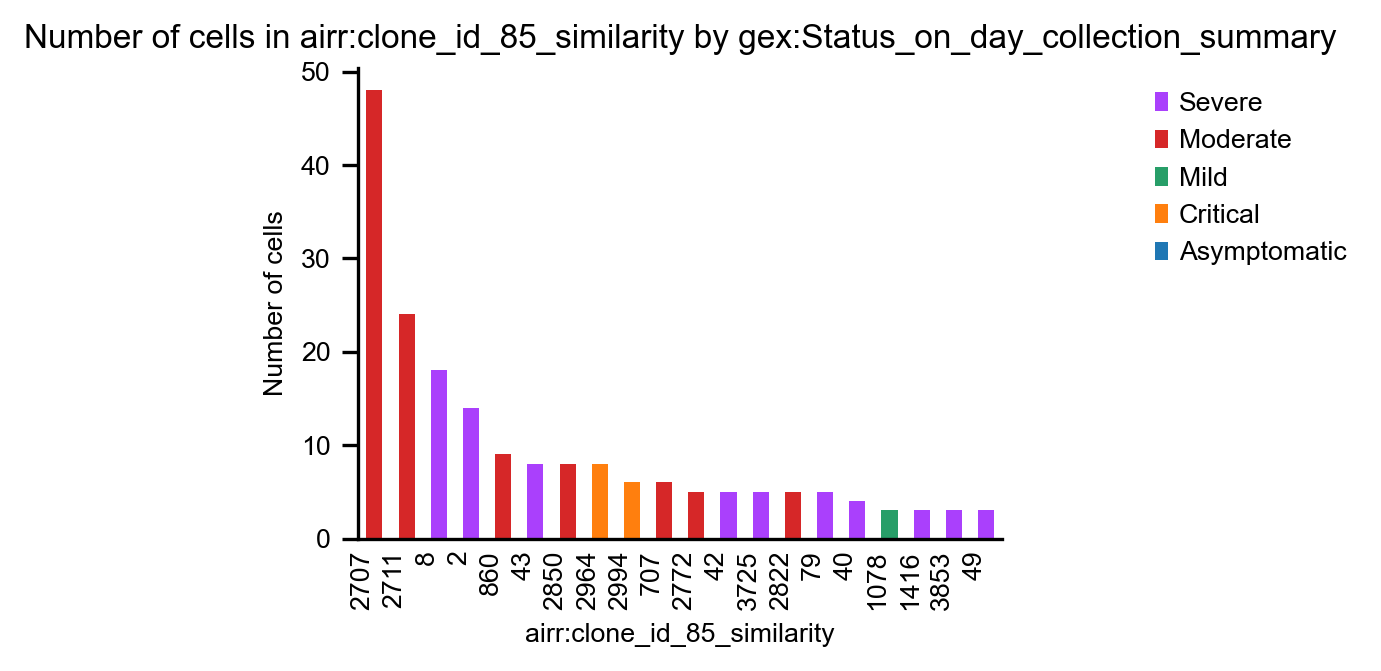

In [26]:
ax_groups = ir.pl.group_abundance(
    mdata, 
    groupby="airr:clone_id_85_similarity",
    target_col="gex:Status_on_day_collection_summary",
    max_cols=20
)
_=ax_groups.set_xticklabels(ax_groups.get_xticklabels(), rotation=90, ha="right")

## Gene usage

It might come handy to permantly add manipulated data from the awkward array to the `.obs` columns to access it easily for visualization. For example, it might be interesting to do comparison of gene family usage, which is not specifically stored in the MuData object, but can be derived from the gene annotation call as done with the code below.

In [27]:
v_calls = ir.get.airr(mdata, "v_call")
mdata["airr"].obs["VDJ_1_v_family"] = [None if a==None else a.split("-")[0] for a in v_calls["VDJ_1_v_call"]]
mdata["airr"].obs["VDJ_2_v_family"] = [None if a==None else a.split("-")[0] for a in v_calls["VDJ_2_v_call"]]
mdata["airr"].obs["VJ_1_v_family"] = [None if a==None else a.split("-")[0] for a in v_calls["VJ_1_v_call"]]
mdata["airr"].obs["VJ_2_v_family"] = [None if a==None else a.split("-")[0] for a in v_calls["VJ_2_v_call"]]
mdata.update()

Gene annotation can be utilized to investigate gene usage for a various of categories like patient categories (Status) or celltype annotation. By using `scirpy.get.airr_context` any column from the awkward array can be temporary added to the MuData object.<br>
Below this was applied to visualize gene usage for patient-status and for gene families, respectively. Note that a lot of the most used genes belong to IGHV3 and IGHV4.

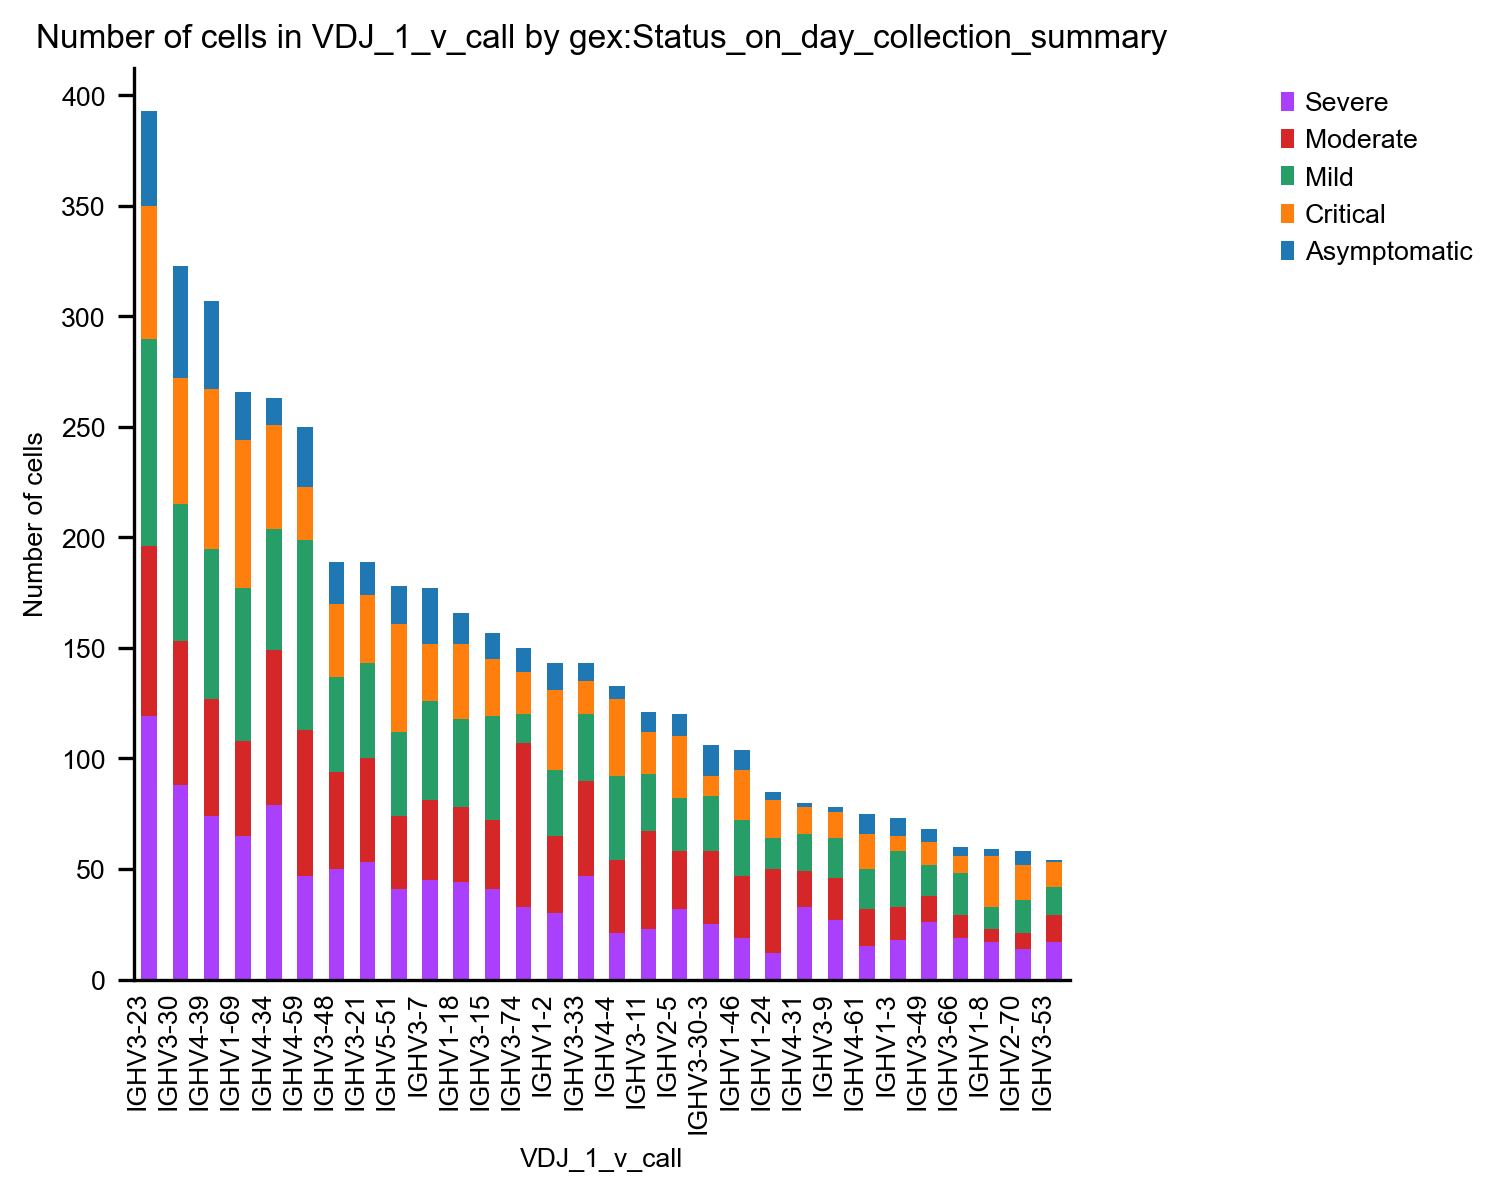

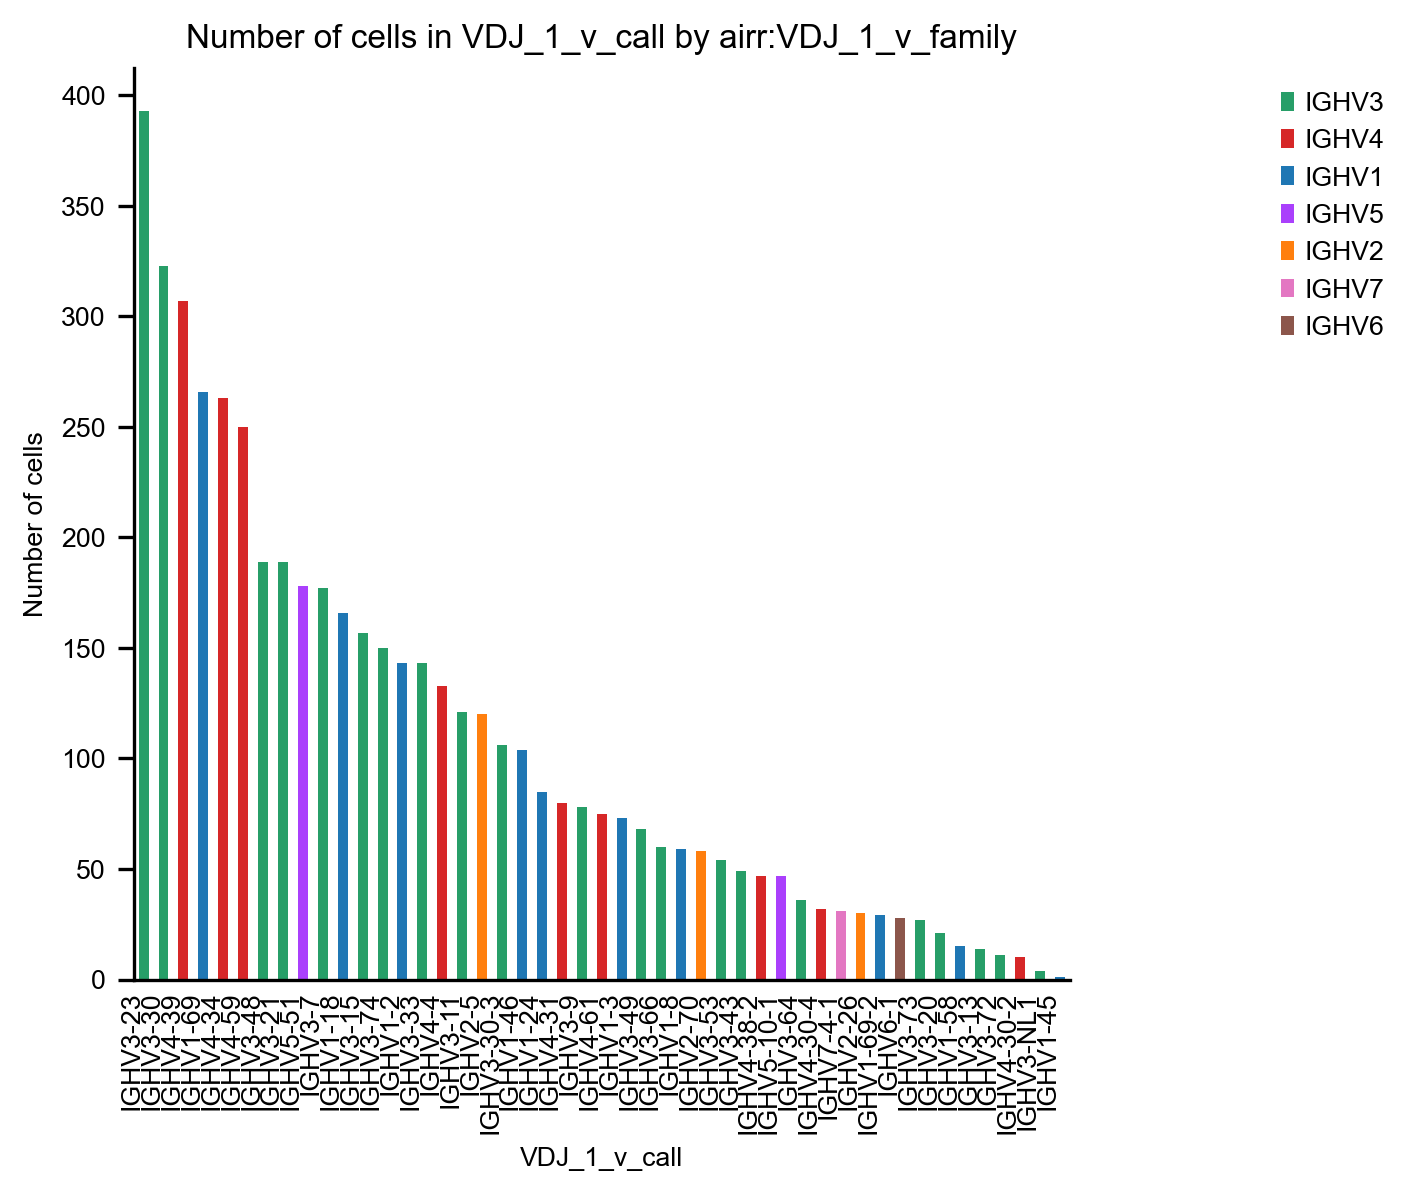

In [52]:
with ir.get.airr_context(mdata,"v_call"):
    ax_Status=ir.pl.group_abundance(
        mdata,
        groupby="VDJ_1_v_call",
        target_col="gex:Status_on_day_collection_summary",
        normalize=False,
        max_cols = 30,
        figsize=(5,5)
    )
_=ax_Status.set_xticklabels(ax_Status.get_xticklabels(), rotation=90, ha="right")

with ir.get.airr_context(mdata,"v_call"):
    ax1 = ir.pl.group_abundance(mdata,
                            groupby = "VDJ_1_v_call",
                            target_col = "airr:VDJ_1_v_family",
                            figsize=(5,5))
_=ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="right")

To see an overview of the exact combination of V(D)J genes the `scirpy.pl.vdj_usage` function can be used. It plots all gene combinations of the dataset as a  Sankey-plot.

<Axes: >

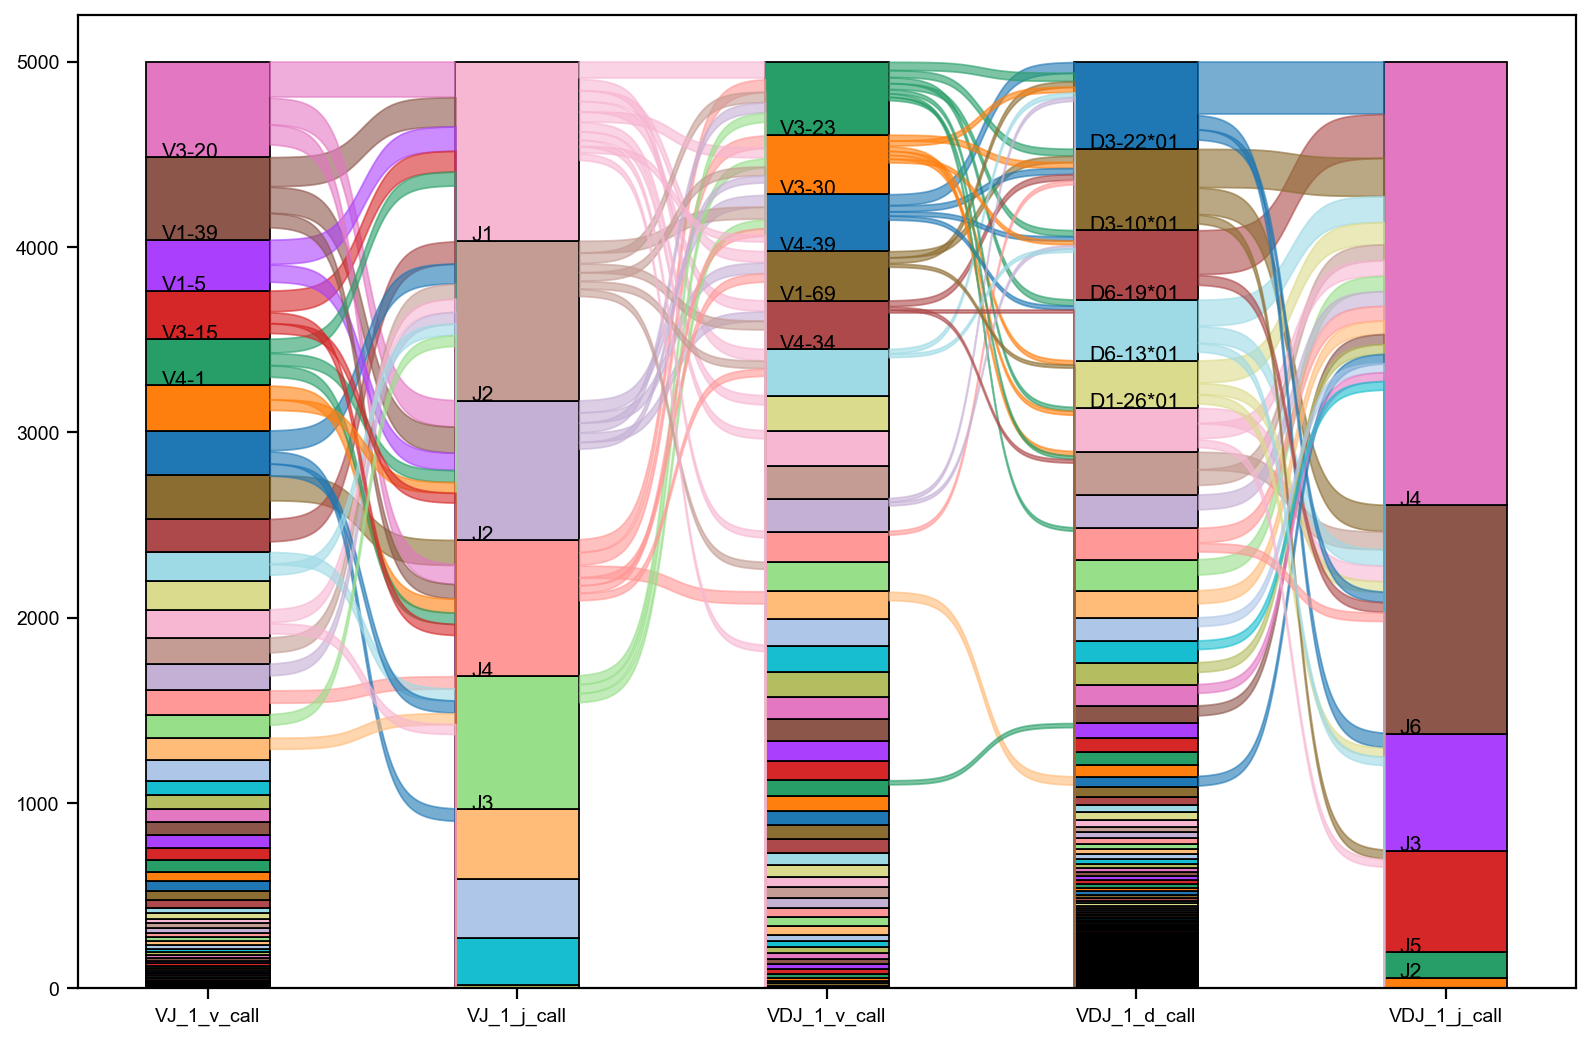

In [30]:
ir.pl.vdj_usage(
    mdata,
    vdj_cols = ('VJ_1_v_call', 'VJ_1_j_call', 'VDJ_1_v_call', 'VDJ_1_d_call', 'VDJ_1_j_call'),
    full_combination=False,
    max_segments=None,
    max_ribbons=30,
    fig_kws={"figsize": (12, 8)},
)

A lot of this tutorial was focused on the primary heavy chain as it's considered to be the most diverse and potentially the most interseting chain for analysis. However analysing the light chain works in a similar manner and yields also very important information. Further, it's possible to analyse allelically included b cells with a secondary heavy and/or light chain contig as well. <br>

### Spectratype analysis
Spectratype analysis is another way to describe heterogenity of the V(D)J sequences. Briefly, during gene rearrangement (V(D)J recombination) randomly two (light chain) or three (heavy chain) types of gene segments are spliced together to build the variable doamain of the repsective AIR. This process is prone to errors so that there is also always the possibility that Insertions and/or Deletions of nucleotides between genes segments occur. Both mechanism combined result into a broad variety of possible lengths of the resulting transcript [Kenneth and Casey, 2017](https://inmunologos.files.wordpress.com/2020/08/janeways-immunobiology-9th-ed_booksmedicos.org_.pdf). Here in `Scirpy` it's rather easy to visualize this Spectratype distribution by summarizin the length of the junction (CDR3) region for all cells and chains. `Scirpy` comes with its own function `scirpy.pl.spectratype` that plots this distribution with plenty of possibilities for customization.<br>
The exact junction length of each chain can be derived from the awkward array and stored permantly as a `.obs` column to access with non-scripy functions as shon below.

In [32]:
junction_length_aa = ir.get.airr(mdata, "junction_aa")
mdata.obs["airr:VDJ_1_junction_length_aa"] = [len(a) for a in junction_length_aa["VDJ_1_junction_aa"]]
mdata.obs["airr:VJ_1_junction_length_aa"] = [len(a) for a in junction_length_aa["VJ_1_junction_aa"]]
mdata.obs["airr:VDJ_2_junction_length_aa"] = [None if a == None else len(a) for a in junction_length_aa["VDJ_2_junction_aa"]]
mdata.obs["airr:VJ_2_junction_length_aa"] = [None if a == None else len(a) for a in junction_length_aa["VJ_2_junction_aa"]]
mdata.update()

Using `scirpy.pl.spectratype` shows that while the spectratype distribution of the whole dataset is almost a normal distribution with a peak at 16 aminoacids, there might be a preferential usage of spectratypes with length 20 for expanded clonotype clusters. Note that spectratypes of length 16 in expanded cells are far less abundant than expected after seeing the spectratype distribution of the whole dataset.

C:\Users\km930\project\scirpy_BCR\scirpy\tl\_spectratype.py:75: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  obs["lengths"] = airr_df.applymap(len).apply(combine_fun, axis=1)


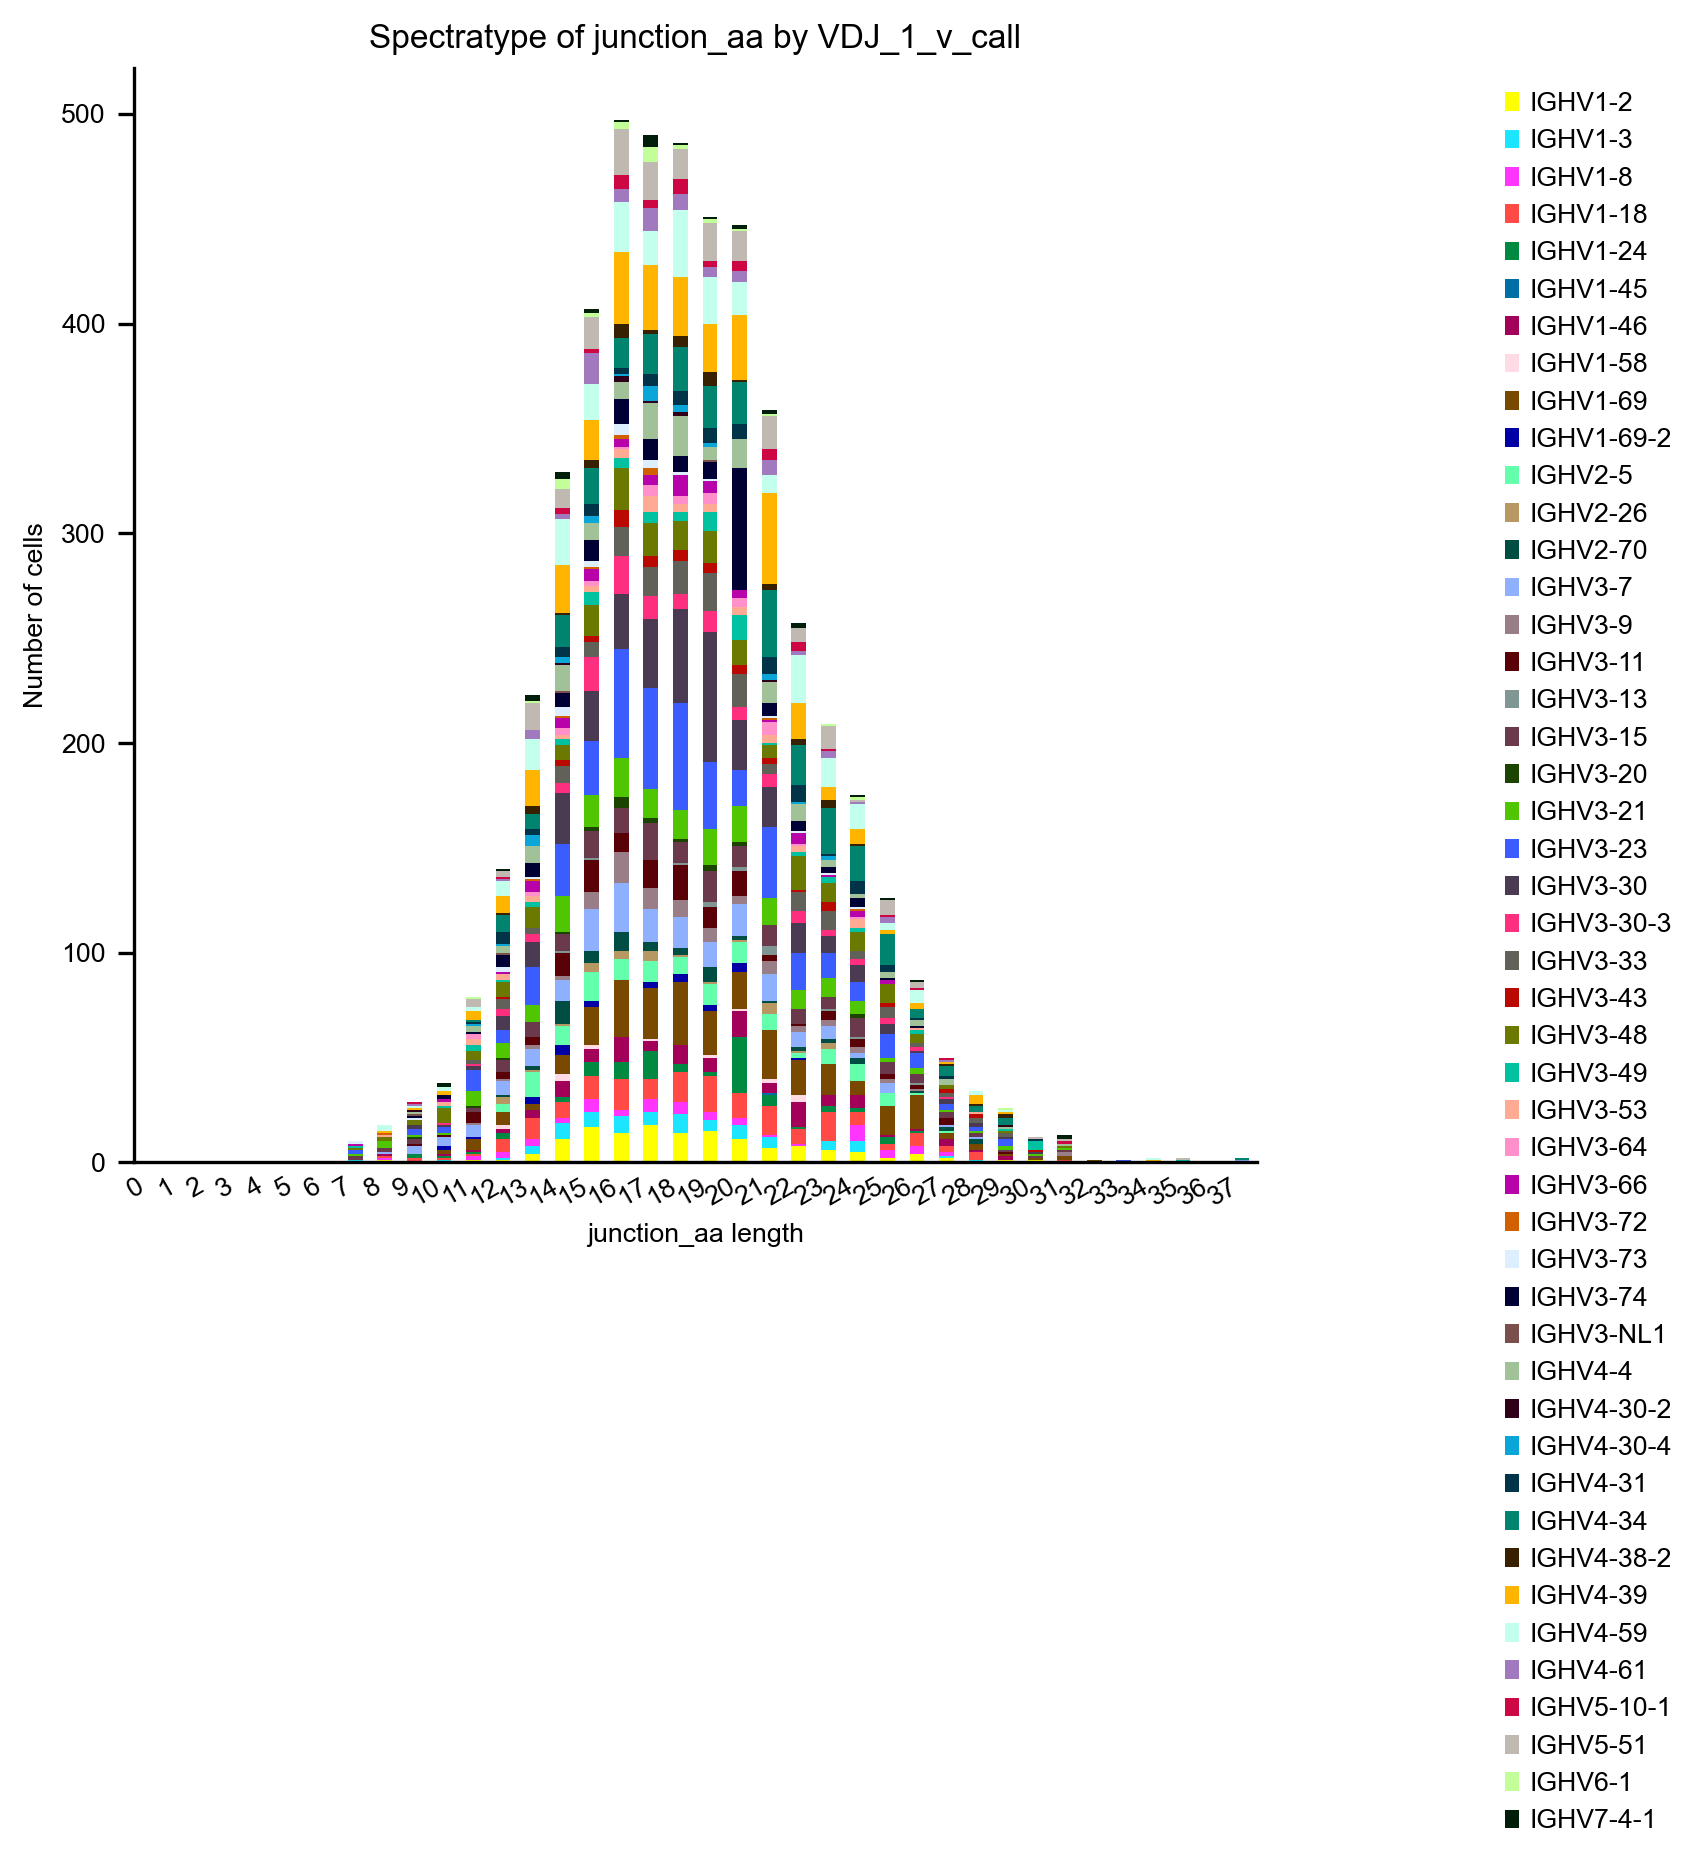

In [53]:
with ir.get.airr_context(mdata,"v_call"):
    ir.pl.spectratype(mdata,
                  chain = ["VDJ_1"],
                  color="VDJ_1_v_call",
                  viztype="bar",
                  fig_kws={"dpi": 120},
                  figsize=[6,6])

C:\Users\km930\project\scirpy_BCR\scirpy\tl\_spectratype.py:75: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  obs["lengths"] = airr_df.applymap(len).apply(combine_fun, axis=1)


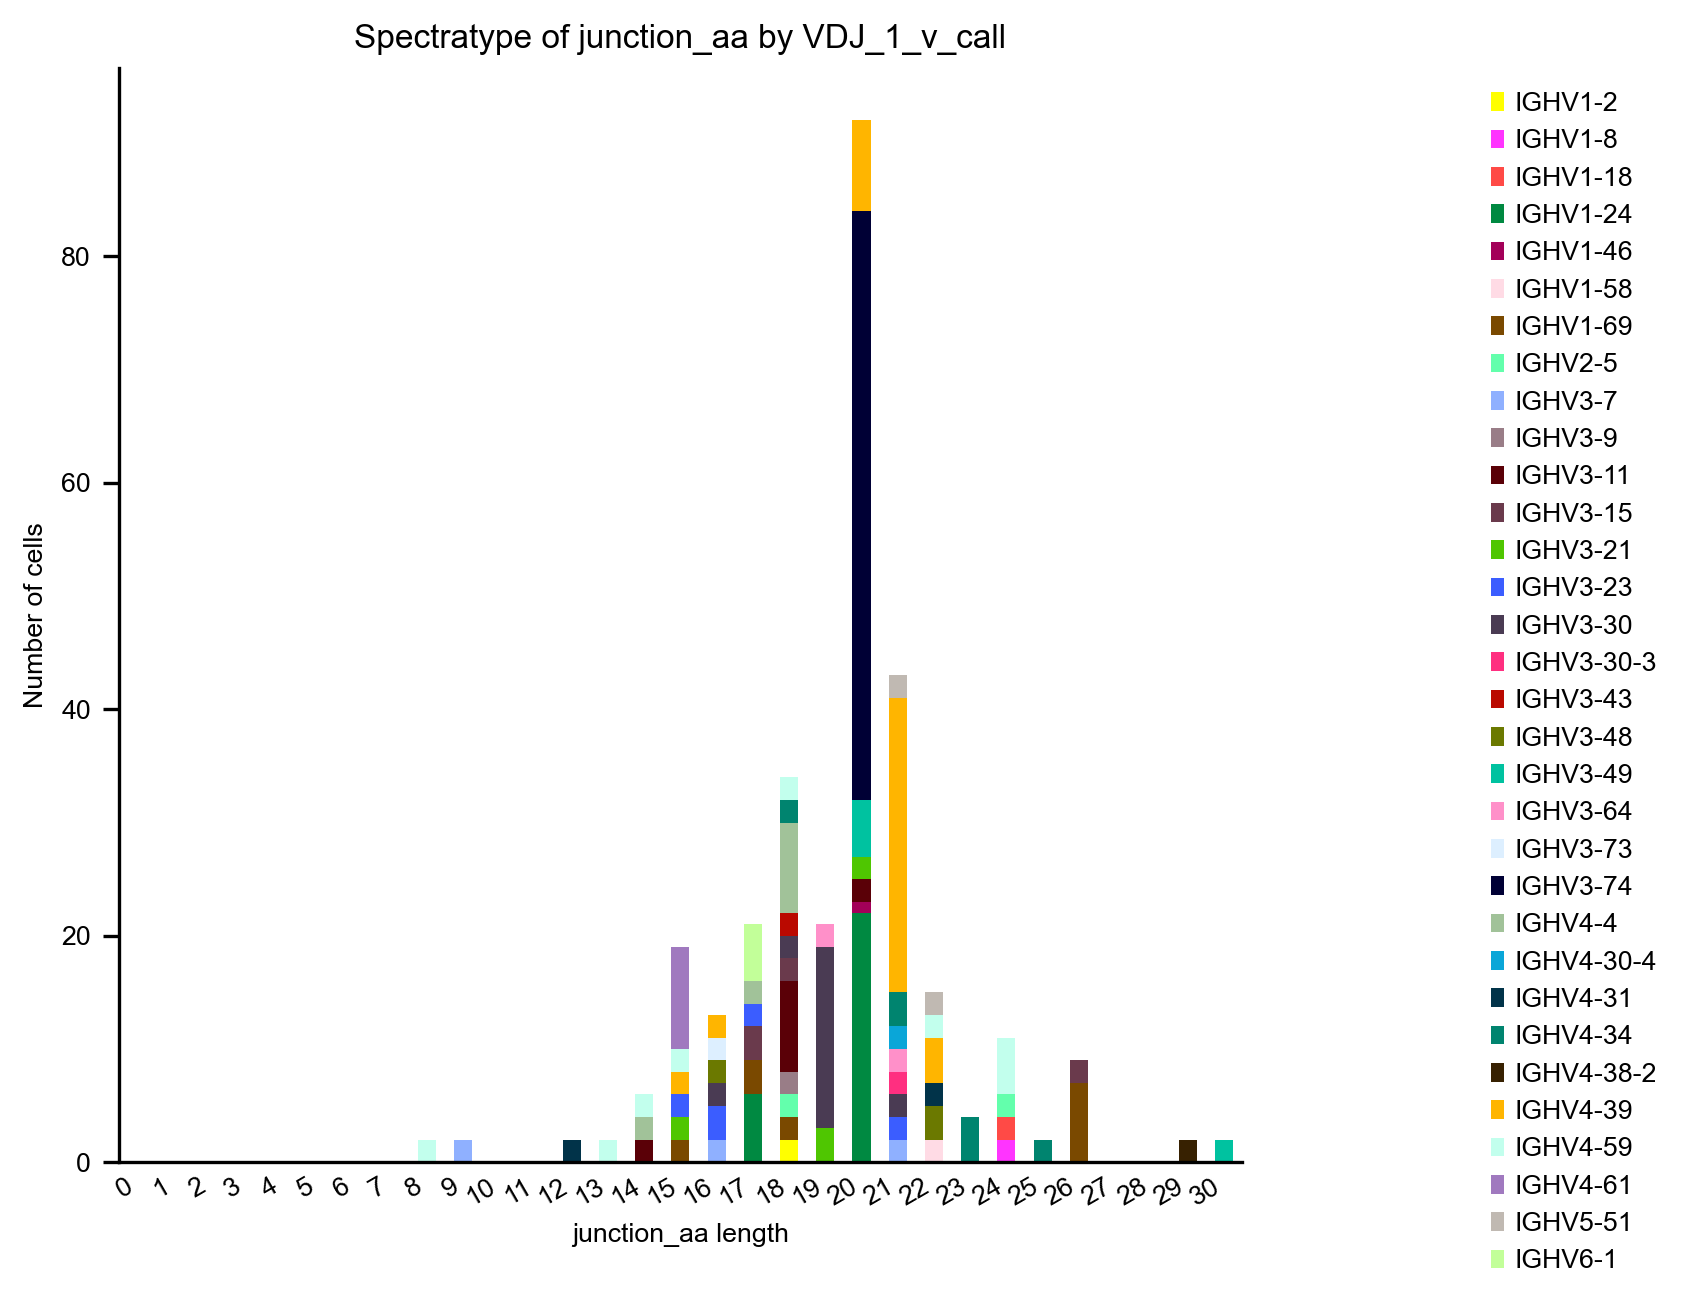

In [34]:
with ir.get.airr_context(mdata,"v_call"):
    ir.pl.spectratype(
        mdata[
            mdata.obs["airr:clonal_expansion"].isin(['<= 2', '> 2']),
            :,
        ],
        chain = ["VDJ_1"],
        cdr3_col = "junction_aa",
        color="VDJ_1_v_call",
        viztype="bar",
        fig_kws={"dpi": 120},
        figsize=[6,6],
    )

Probably a better way to visualize the spectratpe distribution between different categories of cells/patients is by changing the `viztype` parameter to "curve" and the `curve_layout` to "shifted". This will visualize all distinct categories as a "ridge-plot". Differences might be better observational this way.

C:\Users\km930\project\scirpy_BCR\scirpy\tl\_spectratype.py:75: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  obs["lengths"] = airr_df.applymap(len).apply(combine_fun, axis=1)
C:\Users\km930\project\scirpy_BCR\scirpy\pl\base.py:261: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(order)


<Axes: title={'center': 'Spectratype of junction_aa by gex:full_clustering'}, xlabel='junction_aa length'>

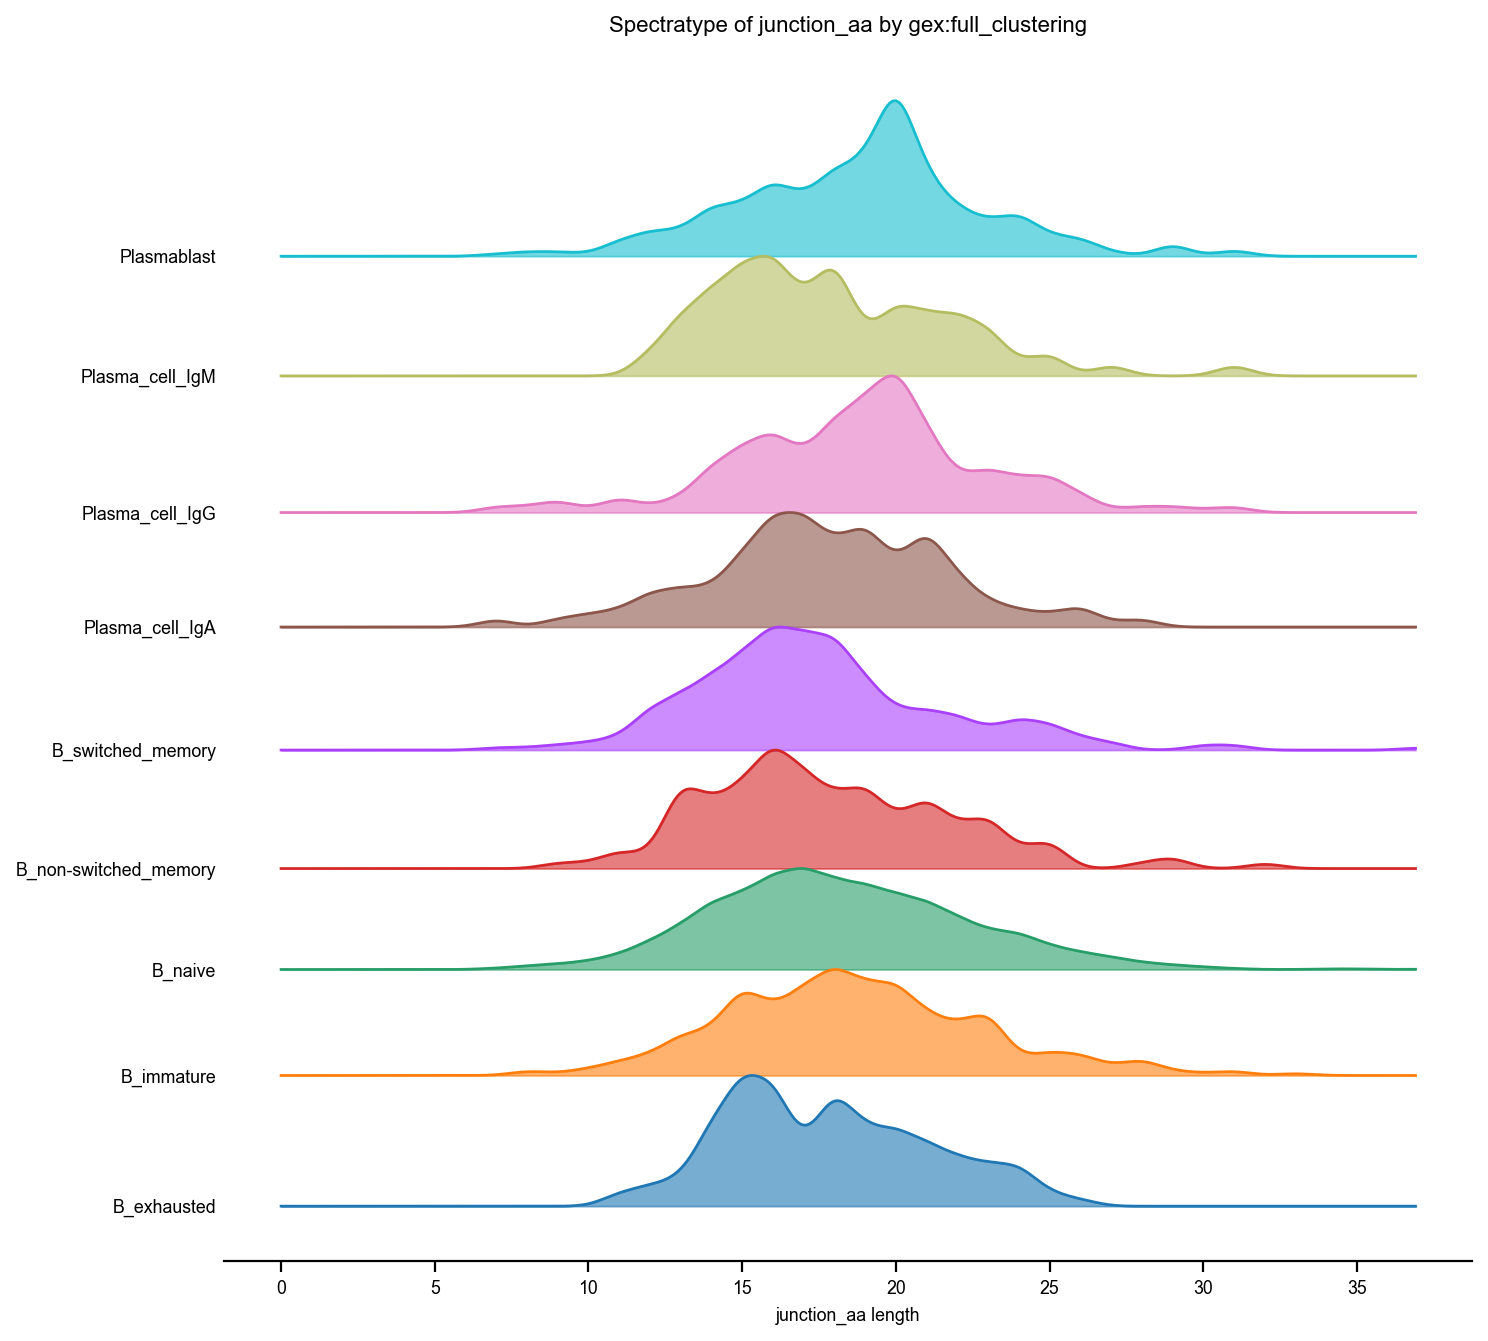

In [35]:
ir.pl.spectratype(
    mdata,
    cdr3_col="junction_aa",
    chain = "VDJ_1",
    color="gex:full_clustering",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"figsize": [10, 10]},
    kde_kws={"kde_norm": False},
)

Furthermore, the `scirpy.tl.spectratype` function is the foundation of the above introduced plots and can be effectively used on it own, too. For example, it's easy to identify all gene annotations used in a transcript with a certain junction lengh that were expanded. These information are particulary useful for sequence motif plots as described in the Logoplot section. Here, we can easily extract all the genes of a certain length for expanded clonotype cluster.

In [63]:
with ir.get.airr_context(mdata, "v_call"):
    genes_expanded_len_16 =ir.tl.spectratype(mdata[mdata.obs["airr:clone_id_85_similarity_size"] >=2],
                  chain = ["VDJ_1"],
                  target_col="VDJ_1_v_call",
                  viztype="bar",
                  fig_kws={"dpi": 120},
                  figsize=[8,8]).loc[16].sort_values(ascending = False).index[:6].to_list()

    genes_expanded_len_20 = ir.tl.spectratype(mdata[mdata.obs["airr:clone_id_85_similarity_size"] >=2],
                  chain = ["VDJ_1"],
                  target_col="VDJ_1_v_call",
                  viztype="bar",
                  fig_kws={"dpi": 120},
                  figsize=[8,8]).loc[20].sort_values(ascending = False)[:5].index.to_list()

C:\Users\km930\project\scirpy_BCR\scirpy\tl\_spectratype.py:75: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  obs["lengths"] = airr_df.applymap(len).apply(combine_fun, axis=1)
C:\Users\km930\project\scirpy_BCR\scirpy\tl\_spectratype.py:75: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  obs["lengths"] = airr_df.applymap(len).apply(combine_fun, axis=1)


Arguably one of the biggest advantages is to seamless use all `Scanpy` functionalities while using `Scirpy` for analysis. So instead of analysing/visualizing categorical data via "ridge"-plots it's entirely possible to use a violinplot as well. Because `Scanpy` doesn't support MuData (yet) we'll have to introduce a small workaround. The function `ir.get.obs_context` allows to temporary store any relevant information into the `.obs` column. Here it can be used to temporarely store information from one modality and transfer it into another modality. This way, the subset of only one modality can be utilized as an AnnData object, which will work just fine for `Scanpy` functions. <br>
Below, this was aplied to create a violinplot with Scanpy's `scanpy.pl.violin` function to better observe potential differences among patient-status groups.

C:\Users\km930\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


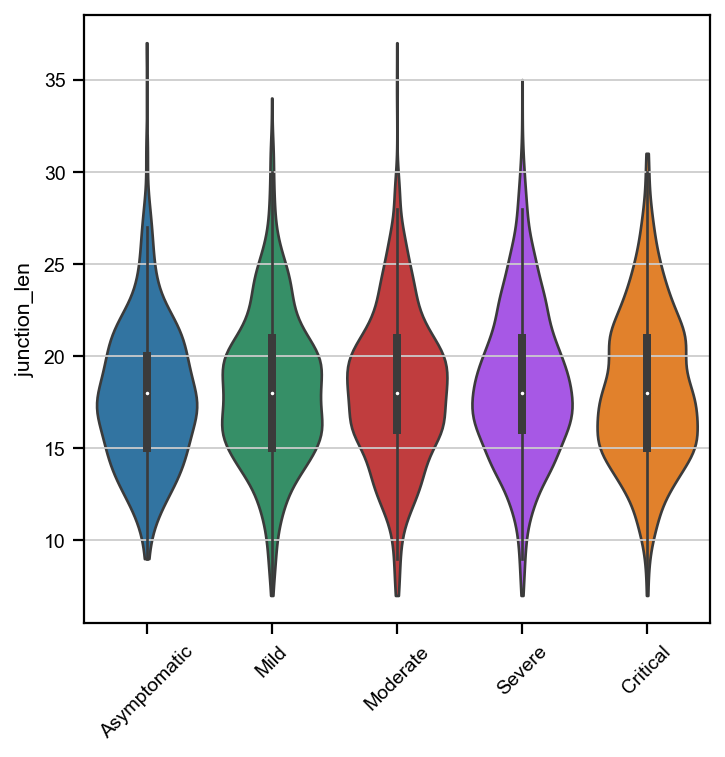

In [58]:
with ir.get.obs_context(
    mdata["gex"], {"junction_len": mdata.obs["airr:VDJ_1_junction_length_aa"]}
) as m:
    sc.pl.violin(m,
                 "junction_len",
                 groupby="Status_on_day_collection_summary",
                 stripplot=False,
                 inner='box',
                 rotation = 45,
                 order = ["Asymptomatic", "Mild","Moderate", "Severe", "Critical"])

## Logoplots
Motif sequence analysis is a crucial analysis step and is often executed through generation of logoplots with respective tools. Currently, `Scirpy` comes with a convenient wrapper function to a well established python package called [palmotif](https://github.com/agartland/palmotif). The function `scirpy.pl.logoplot_cdr3_motif` takes in arguments to specify which cdr3 length and which gene annotations should be included for the generation of the plot. For the below plots, information obtained from spectratype analysis was used to identify gene annotations that might contain interesting motifs.<br>
Each letter represents an aminoacid encountered in the subset of the analyzed dataset encoded by the broadly used aminoacid one letter code. The size of the letter represents how often this letter was found at this position across the dataset. For example, the third to last aminacid has a high probability to be an D (aspartic acid) over being anything else in both logoplots despite differeces in length.<br>
Note that for more advanced logoplots, it might be beneficial to use one of the many webapplications available or to directly use `palmotif` although it might be tricky at first to utilize AnnData/MuData objects within this package.

The logoplot below shows the likelihood of any amino acid to occure among all found genes in expanded clonotype cluster with a spectratype of 16. Here it can be derived that all considered junctions started with a C and ended with a W. Also position 13 is most liekly to be a D and position 1 is often a A. However, from position 3 to 11 there is no clear preferential used aa and thus it's hard to tell from this plot alone if there are any remarkable sequence motifs

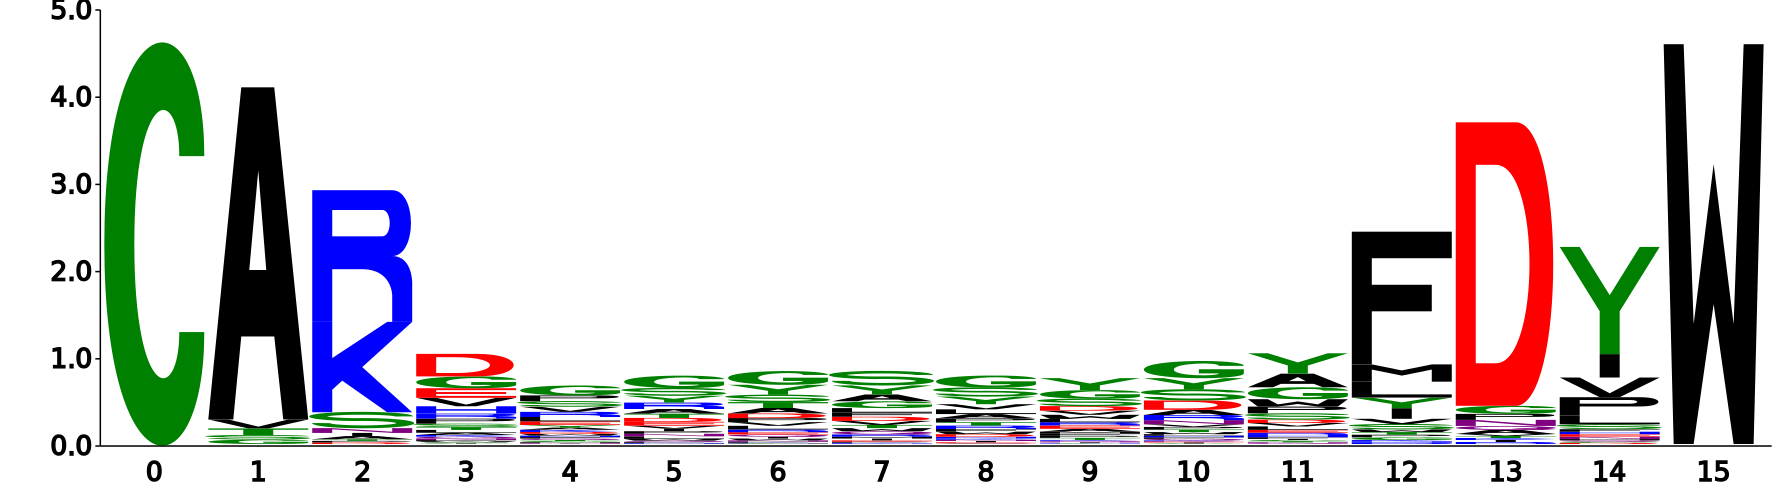

In [64]:
ir.pl.logoplot_cdr3_motif(mdata,
                          cdr_len = 16,
                          target_col = "v_call",
                          cdr3_col = "junction_aa",
                          color_scheme="chemistry",
                          chains = "VDJ_1",
                          gene_annotation= genes_expanded_len_16
                         )

The next logoplot is similar to the previous one, but for spectratypes of length 20. Again the first, second, third to last and last aa are dominantly abundant among all observed genes, but all remaining positions are once again more ambiguous. However, here it might be possible that some underlying sequence motifs are present, but that might need the use of more sophisticated methods than currently available in Scirpy.

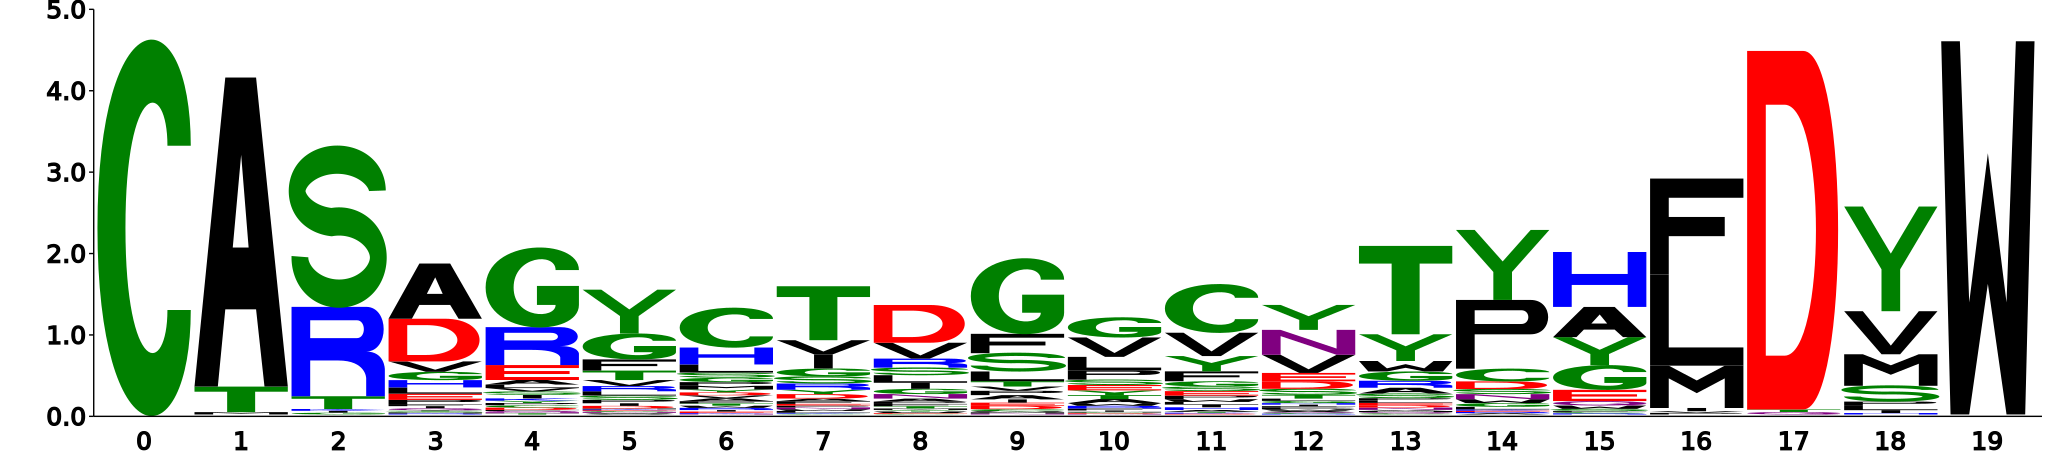

In [65]:
ir.pl.logoplot_cdr3_motif(mdata,
                          cdr_len = 20,
                          target_col = "v_call",
                          cdr3_col = "junction_aa",
                          color_scheme="chemistry",
                          chains = "VDJ_1",
                          gene_annotation= genes_expanded_len_20
                         )

## Analysing somatic hypermutation
While the V(D)J-recombination process is quite similar between TCR and BCR sequences, there is one fundamental biological process that clearly diverges between both AIR. This process is called somatic hypermuation (SHM) and only takes place in activated B cells as part of the affinity maturation. This process further increases the diversity of the variable domaine of the BCR and selects for cells with higher affinity [Kenneth and Casey, 2017](https://inmunologos.files.wordpress.com/2020/08/janeways-immunobiology-9th-ed_booksmedicos.org_.pdf). SHM introduces around one point mutation per 1000 base pairs [Kleinstein et al., 2003](https://pubmed.ncbi.nlm.nih.gov/14568938/) and is able to introduce (although rare) even deletions and/or insertions [Wilson et al., 1998](https://rupress.org/jem/article/187/1/59/25421/Somatic-Hypermutation-Introduces-Insertions-and). Furthermore, it's a broadly accepted consensus that SHM is not a stochastical process, but rather biased in multiple ways like for example via intrinsic hot-spot motifs [Schramm and Douek, 2018](https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2018.01876/full).<br>
Currently, `Scirpy` allows to investigate mutations based on differences between observed sequence and inferred germline sequence. This rather simplistic approach is still widely used and powerful as germline inference tools become increasingly better.<br>
In `Scirpy` this can be done with a new experimental function called `scirpy.tl.mutational_load` which requires both columns containing sequence alignment and germline alignment to be IMGT-gapped. Further, it's best to mask the d-gene as its sequencing is less reliable and might introduce artificial mutations. By setting the `region` parameter to "IMGT_V_segment" only the observed differences inside the V-Region according to the IMGT-unique numbering scheme are counted. This parameter can also be changed to "IMGT_V(D)J" to include the whole sequence and "subregion" to seperately calculate mutations in each distinct region (FWR1, CDR1, FWR2, CDR2, FWR3, CDR3, FWR4).

Calling `scirpy.tl.mutational_load` with `chains` set to VDJ_1 will only add mutational loadinformation about the primary heavy chain as `.obs` columns. Note that by setting `frequency` to False one would yield absolute numbers instead of relative ones.

In [67]:
ir.tl.mutational_load(mdata, chains = ["VDJ_1"], region = "IMGT_V_segment", frequency=True)
ir.tl.mutational_load(mdata, chains = ["VDJ_1"], region = "subregion", frequency=True)

Stored result in `mdata.obs["airr:VDJ_1_v_segment_mu_freq"]`.
Stored result in `mdata.obs["airr:VDJ_1_fwr1_mu_freq"]`.
Stored result in `mdata.obs["airr:VDJ_1_cdr1_mu_freq"]`.
Stored result in `mdata.obs["airr:VDJ_1_fwr2_mu_freq"]`.
Stored result in `mdata.obs["airr:VDJ_1_cdr2_mu_freq"]`.
Stored result in `mdata.obs["airr:VDJ_1_fwr3_mu_freq"]`.
Stored result in `mdata.obs["airr:VDJ_1_cdr3_mu_freq"]`.
Stored result in `mdata.obs["airr:VDJ_1_fwr4_mu_freq"]`.


These `.obs` column are easy accessible in `Scanpy` or `Seaborn` for visualization. Below violinplots show the mutation in each heavy chain V-Region per cell cluster annotation. For example, cells labelled as immature or naive B cells are often not or only very little mutated, which is somewhat expectable. On the other hand, memory B cells, plasma cells and plasmablasts are mutated much more frequently.

C:\Users\km930\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


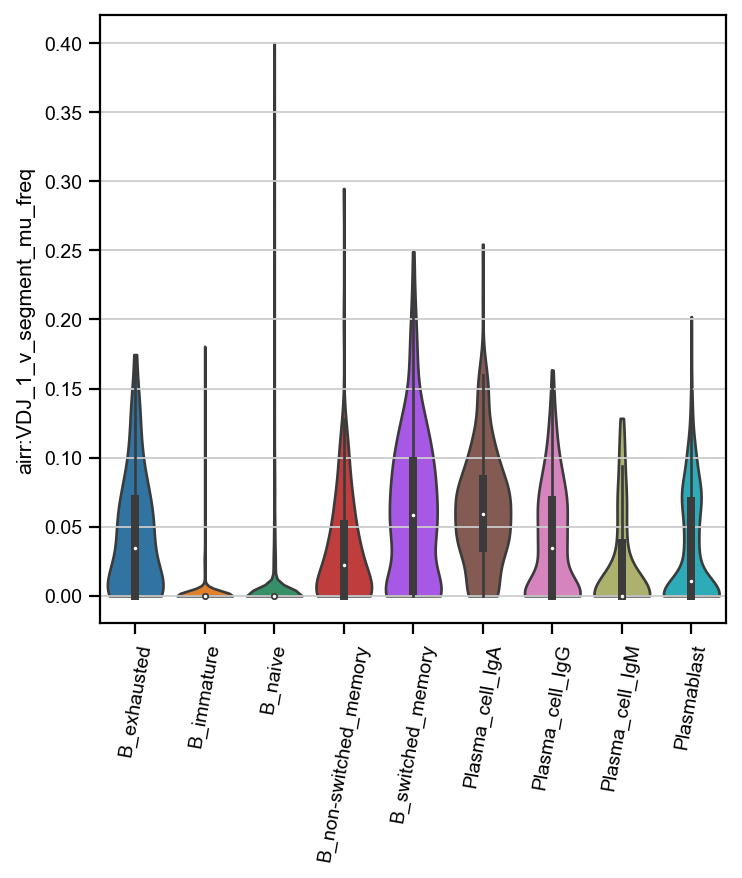

In [70]:
sc.pl.violin(mdata,
             ["airr:VDJ_1_v_segment_mu_freq"],
             groupby= "gex:full_clustering",
             stripplot=False,
             inner='box',
             rotation=80
            )

The next violin plots should only serve to highlight the usage of setting `region` to "subregion" as FWR1-4 and CDR1-3 can be accessed independently. Here, it's clear that CDR are more mutated than FWR, which is consistent with the literature.

C:\Users\km930\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\km930\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\km930\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

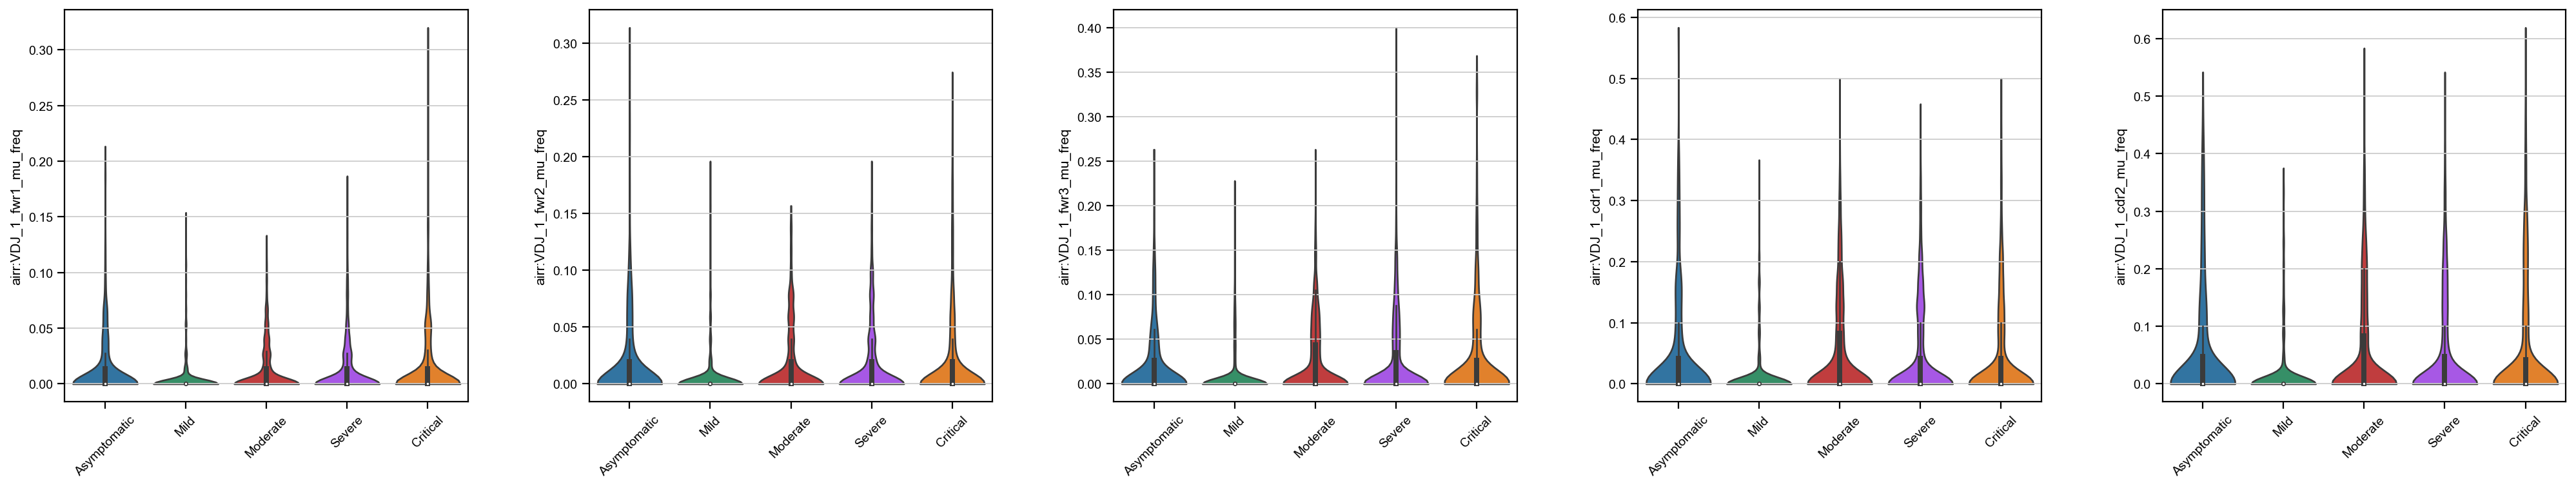

In [73]:
sc.pl.violin(mdata,
             ["airr:VDJ_1_fwr1_mu_freq", "airr:VDJ_1_fwr2_mu_freq", "airr:VDJ_1_fwr3_mu_freq",
              "airr:VDJ_1_cdr1_mu_freq", "airr:VDJ_1_cdr2_mu_freq"],
             groupby= "gex:Status_on_day_collection_summary",
             stripplot=False,
             inner='box',
             rotation=45,
             order = ["Asymptomatic", "Mild","Moderate", "Severe", "Critical"]
            )